# Project 8: Backtesting

In this project, you will build a fairly realistic backtester that uses the Barra data. The backtester will perform portfolio optimization that includes transaction costs, and you'll implement it with computational efficiency in mind, to allow for a reasonably fast backtest. You'll also use performance attribution to identify the major drivers of your portfolio's profit-and-loss (PnL). You will have the option to modify and customize the backtest as well.


## Instructions

Each problem consists of a function to implement and instructions on how to implement the function.  The parts of the function that need to be implemented are marked with a `# TODO` comment. Your code will be checked for the correct solution when you submit it to Udacity.


## Packages

When you implement the functions, you'll only need to you use the packages you've used in the classroom, like [Pandas](https://pandas.pydata.org/) and [Numpy](http://www.numpy.org/). These packages will be imported for you. We recommend you don't add any import statements, otherwise the grader might not be able to run your code.

### Install Packages

In [1]:
import sys
!{sys.executable} -m pip install -r requirements.txt

    100% |████████████████████████████████| 17.3MB 1.7MB/s eta 0:00:01   49% |████████████████                | 8.7MB 20.4MB/s eta 0:00:01
    100% |████████████████████████████████| 10.1MB 7.5MB/s eta 0:00:01
    100% |████████████████████████████████| 235kB 40.6MB/s ta 0:00:01
    100% |████████████████████████████████| 48.2MB 780kB/s eta 0:00:01
    100% |████████████████████████████████| 7.4MB 8.9MB/s eta 0:00:01
    100% |████████████████████████████████| 61kB 16.9MB/s ta 0:00:01
tensorflow 1.3.0 requires tensorflow-tensorboard<0.2.0,>=0.1.0, which is not installed.
moviepy 0.2.3.2 has requirement tqdm==4.11.2, but you'll have tqdm 4.19.5 which is incompatible.
  Found existing installation: numpy 1.12.1
    Uninstalling numpy-1.12.1:
      Successfully uninstalled numpy-1.12.1
  Found existing installation: pandas 0.23.3
    Uninstalling pandas-0.23.3:
      Successfully uninstalled pandas-0.23.3
  Found existing installation: patsy 0.4.1
    Uninstalling patsy-0.4.1:
      Succe

### Load Packages

In [2]:
import scipy
import patsy
import pickle

import numpy as np
import pandas as pd

import scipy.sparse
import matplotlib.pyplot as plt

from statistics import median
from scipy.stats import gaussian_kde
from statsmodels.formula.api import ols
from tqdm import tqdm

## Load Data

We’ll be using the Barra dataset to get factors that can be used to predict risk. Loading and parsing the raw Barra data can be a very slow process that can significantly slow down your backtesting. For this reason, it's important to pre-process the data beforehand. For your convenience, the Barra data has already been pre-processed for you and saved into pickle files. You will load the Barra data from these pickle files.

In the code below, we start by loading `2004` factor data from the `pandas-frames.2004.pickle` file. We also load the `2003` and `2004` covariance data from the `covaraince.2003.pickle`  and `covaraince.2004.pickle` files. You are encouraged  to customize the data range for your backtest. For example, we recommend starting with two or three years of factor data. Remember that the covariance data should include all the years that you choose for the factor data,   and also one year earlier. For example, in the code below we are using  `2004` factor data, therefore, we must include `2004` in our covariance data, but also the previous year, `2003`. If you don't remember why must include this previous year, feel free to review the lessons.

In [3]:
barra_dir = '../../data/project_8_barra/'

data = {}
for year in [2004]:
    fil = barra_dir + "pandas-frames." + str(year) + ".pickle"
    data.update(pickle.load( open( fil, "rb" ) ))
    
covariance = {}
for year in [2003, 2004]:
    fil = barra_dir + "covariance." + str(year) + ".pickle"
    covariance.update(pickle.load( open(fil, "rb" ) ))
    
daily_return = {}
for year in [2004, 2005]:
    fil = barra_dir + "price." + str(year) + ".pickle"
    daily_return.update(pickle.load( open(fil, "rb" ) ))

## Shift Daily Returns Data (TODO)

In the cell below, we want to incorporate a realistic time delay that exists in live trading, we’ll use a two day delay for the `daily_return` data. That means the `daily_return` should be two days after the data in `data` and `cov_data`. Combine `daily_return` and `data` together in a dict called `frames`.

Since reporting of PnL is usually for the date of the returns, make sure to use the two day delay dates (dates that match the `daily_return`) when building `frames`. This means calling `frames['20040108']` will get you the prices from "20040108" and the data from `data` at "20040106".

Note: We're not shifting `covariance`, since we'll use the "DataDate" field in `frames` to lookup the covariance data. The "DataDate" field contains the date when the `data` in `frames` was recorded. For example, `frames['20040108']` will give you a value of "20040106" for the field "DataDate".

In [4]:
frames ={}
dlyreturn_n_days_delay = 2

# DONE: Implement

# Prepare a list of tuples pairing 'data' dates with their corresponding 'daily_return' dates, considering the delay
shifted_dates = zip(
    sorted(data.keys()), 
    sorted(daily_return.keys())[dlyreturn_n_days_delay : len(data) + dlyreturn_n_days_delay]
)

# Iterate over each pair of dates
for date, shifted_date in shifted_dates:
    # ensure both dates exist in their respective datasets before attempting to merge
    if date in data and shifted_date in daily_return:
        # Merge 'data' and 'daily_return' based on 'Barrid'
        frames[shifted_date] = data[date].merge(daily_return[shifted_date], on='Barrid')
    else:
        print(f"Missing data for merging: data date {date}, daily_return date {shifted_date}")

# check the content of 'frames' to ensure it's populated as expected
for key in list(frames.keys())[:5]:  # Just sample a few entries for inspection
    print(f"Sample frame for date {key}:")
    print(frames[key].head(), "\n")

Sample frame for date 20040106:
    Barrid  USFASTD_1DREVRSL  USFASTD_AERODEF  USFASTD_AIRLINES  \
0  USA0001            -0.032            0.000               0.0   
1  USA0011            -0.059            0.000               0.0   
2  USA0031             0.457            0.000               0.0   
3  USA0062            -0.128            0.431               0.0   
4  USA00E2             0.374            0.000               0.0   

   USFASTD_ALUMSTEL  USFASTD_APPAREL  USFASTD_AUTO  USFASTD_BANKS  \
0               0.0              0.0           0.0            0.0   
1               0.0              0.0           0.0            0.0   
2               0.0              0.0           0.0            0.0   
3               0.0              0.0           0.0            0.0   
4               0.0              0.0           0.0            0.0   

   USFASTD_BETA  USFASTD_BEVTOB  ...  DailyVolume  ADTCA_30  IssuerMarketCap  \
0        -2.177             0.0  ...          NaN       NaN     5.3929

## Add Daily Returns date column (Optional)
Name the column `DlyReturnDate`.
**Hint**: create a list containing copies of the date, then create a pandas series.

In [5]:


# Optional

for date, df in daily_return.items():
    # Calculate the number of rows in the current DataFrame, to create a matching-length series
    n_rows = df.shape[0]
    # Create a new column 'DlyReturnDate' filled with the current date
    # Ensures that every row in this DataFrame is tagged with the date of the daily return
    df['DlyReturnDate'] = pd.Series([date] * n_rows)
    
    # Verify if the 'DlyReturnDate' column is added correctly
    if 'DlyReturnDate' not in df.columns:
        print(f"Failed to add 'DlyReturnDate' for date: {date}")
    else:
        # Print a success message with a sample row to verify the correct addition of the 'DlyReturnDate' column
        print(f"'DlyReturnDate' added successfully for date: {date}. Sample row:\n{df.head(1)}")

'DlyReturnDate' added successfully for date: 20040102. Sample row:
     Barrid  DlyReturn DlyReturnDate
76  USA0001        0.0      20040102
'DlyReturnDate' added successfully for date: 20040105. Sample row:
     Barrid  DlyReturn DlyReturnDate
76  USA0001        0.0      20040105
'DlyReturnDate' added successfully for date: 20040106. Sample row:
     Barrid  DlyReturn DlyReturnDate
76  USA0001        0.0      20040106
'DlyReturnDate' added successfully for date: 20040107. Sample row:
     Barrid  DlyReturn DlyReturnDate
76  USA0001        0.0      20040107
'DlyReturnDate' added successfully for date: 20040108. Sample row:
     Barrid  DlyReturn DlyReturnDate
76  USA0001        0.0      20040108
'DlyReturnDate' added successfully for date: 20040109. Sample row:
     Barrid  DlyReturn DlyReturnDate
76  USA0001        0.0      20040109
'DlyReturnDate' added successfully for date: 20040112. Sample row:
     Barrid  DlyReturn DlyReturnDate
76  USA0001        0.0      20040112
'DlyReturnDat

'DlyReturnDate' added successfully for date: 20040331. Sample row:
     Barrid  DlyReturn DlyReturnDate
78  USA0001        0.0      20040331
'DlyReturnDate' added successfully for date: 20040401. Sample row:
     Barrid  DlyReturn DlyReturnDate
77  USA0001        0.0      20040401
'DlyReturnDate' added successfully for date: 20040402. Sample row:
     Barrid  DlyReturn DlyReturnDate
77  USA0001        0.0      20040402
'DlyReturnDate' added successfully for date: 20040405. Sample row:
     Barrid  DlyReturn DlyReturnDate
77  USA0001        0.0      20040405
'DlyReturnDate' added successfully for date: 20040406. Sample row:
     Barrid  DlyReturn DlyReturnDate
77  USA0001        0.0      20040406
'DlyReturnDate' added successfully for date: 20040407. Sample row:
     Barrid  DlyReturn DlyReturnDate
77  USA0001        0.0      20040407
'DlyReturnDate' added successfully for date: 20040408. Sample row:
     Barrid  DlyReturn DlyReturnDate
77  USA0001        0.0      20040408
'DlyReturnDat

'DlyReturnDate' added successfully for date: 20040719. Sample row:
     Barrid  DlyReturn DlyReturnDate
75  USA0001        0.0      20040719
'DlyReturnDate' added successfully for date: 20040720. Sample row:
     Barrid  DlyReturn DlyReturnDate
75  USA0001        0.0      20040720
'DlyReturnDate' added successfully for date: 20040721. Sample row:
     Barrid  DlyReturn DlyReturnDate
75  USA0001        0.0      20040721
'DlyReturnDate' added successfully for date: 20040722. Sample row:
     Barrid  DlyReturn DlyReturnDate
75  USA0001        0.0      20040722
'DlyReturnDate' added successfully for date: 20040723. Sample row:
     Barrid  DlyReturn DlyReturnDate
75  USA0001        0.0      20040723
'DlyReturnDate' added successfully for date: 20040726. Sample row:
     Barrid  DlyReturn DlyReturnDate
75  USA0001        0.0      20040726
'DlyReturnDate' added successfully for date: 20040727. Sample row:
     Barrid  DlyReturn DlyReturnDate
75  USA0001        0.0      20040727
'DlyReturnDat

'DlyReturnDate' added successfully for date: 20041028. Sample row:
     Barrid  DlyReturn DlyReturnDate
74  USA0001        0.0      20041028
'DlyReturnDate' added successfully for date: 20041029. Sample row:
     Barrid  DlyReturn DlyReturnDate
74  USA0001        0.0      20041029
'DlyReturnDate' added successfully for date: 20041101. Sample row:
      Barrid  DlyReturn DlyReturnDate
140  USA0001        0.0      20041101
'DlyReturnDate' added successfully for date: 20041102. Sample row:
      Barrid  DlyReturn DlyReturnDate
140  USA0001        0.0      20041102
'DlyReturnDate' added successfully for date: 20041103. Sample row:
      Barrid  DlyReturn DlyReturnDate
140  USA0001        0.0      20041103
'DlyReturnDate' added successfully for date: 20041104. Sample row:
      Barrid  DlyReturn DlyReturnDate
142  USA0001        0.0      20041104
'DlyReturnDate' added successfully for date: 20041105. Sample row:
      Barrid  DlyReturn DlyReturnDate
142  USA0001        0.0      20041105
'Dl

'DlyReturnDate' added successfully for date: 20050216. Sample row:
      Barrid  DlyReturn DlyReturnDate
147  USA0001        0.0      20050216
'DlyReturnDate' added successfully for date: 20050217. Sample row:
      Barrid  DlyReturn DlyReturnDate
147  USA0001        0.0      20050217
'DlyReturnDate' added successfully for date: 20050218. Sample row:
      Barrid  DlyReturn DlyReturnDate
147  USA0001        0.0      20050218
'DlyReturnDate' added successfully for date: 20050222. Sample row:
      Barrid  DlyReturn DlyReturnDate
147  USA0001        0.0      20050222
'DlyReturnDate' added successfully for date: 20050223. Sample row:
      Barrid  DlyReturn DlyReturnDate
147  USA0001        0.0      20050223
'DlyReturnDate' added successfully for date: 20050224. Sample row:
      Barrid  DlyReturn DlyReturnDate
147  USA0001        0.0      20050224
'DlyReturnDate' added successfully for date: 20050225. Sample row:
      Barrid  DlyReturn DlyReturnDate
147  USA0001        0.0      20050225

'DlyReturnDate' added successfully for date: 20050602. Sample row:
      Barrid  DlyReturn DlyReturnDate
148  USA0001        0.0      20050602
'DlyReturnDate' added successfully for date: 20050603. Sample row:
      Barrid  DlyReturn DlyReturnDate
148  USA0001        0.0      20050603
'DlyReturnDate' added successfully for date: 20050606. Sample row:
      Barrid  DlyReturn DlyReturnDate
148  USA0001        0.0      20050606
'DlyReturnDate' added successfully for date: 20050607. Sample row:
      Barrid  DlyReturn DlyReturnDate
148  USA0001        0.0      20050607
'DlyReturnDate' added successfully for date: 20050608. Sample row:
      Barrid  DlyReturn DlyReturnDate
148  USA0001        0.0      20050608
'DlyReturnDate' added successfully for date: 20050609. Sample row:
      Barrid  DlyReturn DlyReturnDate
148  USA0001        0.0      20050609
'DlyReturnDate' added successfully for date: 20050610. Sample row:
      Barrid  DlyReturn DlyReturnDate
148  USA0001        0.0      20050610

'DlyReturnDate' added successfully for date: 20050829. Sample row:
      Barrid  DlyReturn DlyReturnDate
149  USA0001        0.0      20050829
'DlyReturnDate' added successfully for date: 20050830. Sample row:
      Barrid  DlyReturn DlyReturnDate
149  USA0001        0.0      20050830
'DlyReturnDate' added successfully for date: 20050831. Sample row:
      Barrid  DlyReturn DlyReturnDate
149  USA0001        0.0      20050831
'DlyReturnDate' added successfully for date: 20050901. Sample row:
      Barrid  DlyReturn DlyReturnDate
149  USA0001        0.0      20050901
'DlyReturnDate' added successfully for date: 20050902. Sample row:
      Barrid  DlyReturn DlyReturnDate
149  USA0001        0.0      20050902
'DlyReturnDate' added successfully for date: 20050906. Sample row:
      Barrid  DlyReturn DlyReturnDate
149  USA0001        0.0      20050906
'DlyReturnDate' added successfully for date: 20050907. Sample row:
      Barrid  DlyReturn DlyReturnDate
149  USA0001        0.0      20050907

'DlyReturnDate' added successfully for date: 20051215. Sample row:
      Barrid  DlyReturn DlyReturnDate
148  USA0001        0.0      20051215
'DlyReturnDate' added successfully for date: 20051216. Sample row:
      Barrid  DlyReturn DlyReturnDate
148  USA0001        0.0      20051216
'DlyReturnDate' added successfully for date: 20051219. Sample row:
      Barrid  DlyReturn DlyReturnDate
148  USA0001        0.0      20051219
'DlyReturnDate' added successfully for date: 20051220. Sample row:
      Barrid  DlyReturn DlyReturnDate
148  USA0001        0.0      20051220
'DlyReturnDate' added successfully for date: 20051221. Sample row:
      Barrid  DlyReturn DlyReturnDate
148  USA0001        0.0      20051221
'DlyReturnDate' added successfully for date: 20051222. Sample row:
      Barrid  DlyReturn DlyReturnDate
148  USA0001        0.0      20051222
'DlyReturnDate' added successfully for date: 20051223. Sample row:
      Barrid  DlyReturn DlyReturnDate
148  USA0001        0.0      20051223

## Winsorize

As we have done in other projects, we'll want to avoid extremely positive or negative values in our data. Will therefore create a function, `wins`, that will clip our values to a minimum and maximum range. This process is called **Winsorizing**. Remember that this helps us handle noise, which may otherwise cause unusually large positions.

In [6]:
def wins(x,a,b):
    return np.where(x <= a,a, np.where(x >= b, b, x))

## Density Plot

Let's check our `wins` function by taking a look at the distribution of returns for a single day `20040102`. We will clip our data from `-0.1` to `0.1` and plot it using our `density_plot` function.

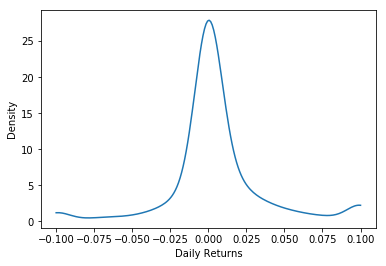

In [7]:
def density_plot(data): 
    density = gaussian_kde(data)
    xs = np.linspace(np.min(data),np.max(data),200)
    density.covariance_factor = lambda : .25
    density._compute_covariance()
    plt.plot(xs,density(xs))
    plt.xlabel('Daily Returns')
    plt.ylabel('Density')
    plt.show()
    
test = frames['20040108']
test['DlyReturn'] = wins(test['DlyReturn'],-0.1,0.1)
density_plot(test['DlyReturn'])

## Factor Exposures and Factor Returns

Recall that:

$r_{i,t} = \sum_{j=1}^{k} (\beta_{i,j,t-2} \times f_{j,t})$  
where $i=1...N$ (N assets),   
and $j=1...k$ (k factors).

where $r_{i,t}$ is the return, $\beta_{i,j,t-2}$ is the factor exposure, and $f_{j,t}$ is the factor return. Since we get the factor exposures from the Barra data, and we know the returns, it is possible to estimate the factor returns. In this notebook, we will use the Ordinary Least Squares (OLS) method to estimate the factor exposures, $f_{j,t}$, by using $\beta_{i,j,t-2}$ as the independent variable, and $r_{i,t}$ as the dependent variable.

In [8]:
def get_formula(factors, Y):
    L = ["0"]
    L.extend(factors)
    return Y + " ~ " + " + ".join(L)

def factors_from_names(n):
    return list(filter(lambda x: "USFASTD_" in x, n))

def estimate_factor_returns(df): 
    ## build universe based on filters 
    estu = df.loc[df.IssuerMarketCap > 1e9].copy(deep=True)
  
    ## winsorize returns for fitting 
    estu['DlyReturn'] = wins(estu['DlyReturn'], -0.25, 0.25)
  
    all_factors = factors_from_names(list(df))
    form = get_formula(all_factors, "DlyReturn")
    model = ols(form, data=estu)
    results = model.fit()
    return results

In [9]:
facret = {}

for date in frames:
    facret[date] = estimate_factor_returns(frames[date]).params

In [10]:
my_dates = sorted(list(map(lambda date: pd.to_datetime(date, format='%Y%m%d'), frames.keys())))

my_dates

[Timestamp('2004-01-06 00:00:00'),
 Timestamp('2004-01-07 00:00:00'),
 Timestamp('2004-01-08 00:00:00'),
 Timestamp('2004-01-09 00:00:00'),
 Timestamp('2004-01-12 00:00:00'),
 Timestamp('2004-01-13 00:00:00'),
 Timestamp('2004-01-14 00:00:00'),
 Timestamp('2004-01-15 00:00:00'),
 Timestamp('2004-01-16 00:00:00'),
 Timestamp('2004-01-20 00:00:00'),
 Timestamp('2004-01-21 00:00:00'),
 Timestamp('2004-01-22 00:00:00'),
 Timestamp('2004-01-23 00:00:00'),
 Timestamp('2004-01-26 00:00:00'),
 Timestamp('2004-01-27 00:00:00'),
 Timestamp('2004-01-28 00:00:00'),
 Timestamp('2004-01-29 00:00:00'),
 Timestamp('2004-01-30 00:00:00'),
 Timestamp('2004-02-02 00:00:00'),
 Timestamp('2004-02-03 00:00:00'),
 Timestamp('2004-02-04 00:00:00'),
 Timestamp('2004-02-05 00:00:00'),
 Timestamp('2004-02-06 00:00:00'),
 Timestamp('2004-02-09 00:00:00'),
 Timestamp('2004-02-10 00:00:00'),
 Timestamp('2004-02-11 00:00:00'),
 Timestamp('2004-02-12 00:00:00'),
 Timestamp('2004-02-13 00:00:00'),
 Timestamp('2004-02-

## Choose Alpha Factors

We will now choose our alpha factors. Barra's factors include some alpha factors that we have seen before, such as:

* **USFASTD_1DREVRSL** : Reversal

* **USFASTD_EARNYILD** : Earnings Yield

* **USFASTD_VALUE** : Value

* **USFASTD_SENTMT** : Sentiment

We will choose these alpha factors for now, but you are encouraged to come back to this later and try other factors as well.

/opt/conda/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


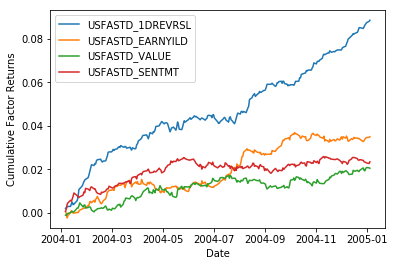

In [11]:
alpha_factors = ["USFASTD_1DREVRSL", "USFASTD_EARNYILD", "USFASTD_VALUE", "USFASTD_SENTMT"]

facret_df = pd.DataFrame(index = my_dates)

for dt in my_dates: 
    for alp in alpha_factors: 
        facret_df.at[dt, alp] = facret[dt.strftime('%Y%m%d')][alp]

for column in facret_df.columns:
        plt.plot(facret_df[column].cumsum(), label=column)
plt.legend(loc='upper left')
plt.xlabel('Date')
plt.ylabel('Cumulative Factor Returns')
plt.show()

## Merge Previous Portfolio Holdings 

In order to optimize our portfolio we will use the previous day's holdings to estimate the trade size and transaction costs. In order to keep track of the holdings from the previous day we will include a column to hold the portfolio holdings of the previous day. These holdings of all our assets will be initialized to zero when the backtest first starts.

In [12]:
def clean_nas(df): 
    numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
    
    for numeric_column in numeric_columns: 
        df[numeric_column] = np.nan_to_num(df[numeric_column])
    
    return df

In [13]:
previous_holdings = pd.DataFrame(data = {"Barrid" : ["USA02P1"], "h.opt.previous" : np.array(0)})
df = frames[my_dates[0].strftime('%Y%m%d')]

df = df.merge(previous_holdings, how = 'left', on = 'Barrid')
df = clean_nas(df)
df.loc[df['SpecRisk'] == 0]['SpecRisk'] = median(df['SpecRisk'])


In [14]:
previous_holdings

,Barrid,h.opt.previous
0,USA02P1,0


In [15]:
df.tail()

,Barrid,USFASTD_1DREVRSL,USFASTD_AERODEF,USFASTD_AIRLINES,USFASTD_ALUMSTEL,USFASTD_APPAREL,USFASTD_AUTO,USFASTD_BANKS,USFASTD_BETA,USFASTD_BEVTOB,...,ADTCA_30,IssuerMarketCap,Yield,TotalRisk,SpecRisk,HistBeta,PredBeta,DataDate,DlyReturn,h.opt.previous
12430,USAZZL1,1.895,0.0,0.0,0.0,0.0,0.0,0.0,-0.318,0.0,...,0.00,3.430560e+07,0.000000,58.542009,53.503883,0.855973,1.148298,20040102,0.068966,0.0
12431,USAZZP1,2.410,0.0,0.0,0.0,0.0,0.0,0.0,-1.100,1.0,...,0.00,2.614480e+06,0.000000,79.293774,76.269788,0.495782,0.872594,20040102,0.000000,0.0
12432,USAZZR1,2.120,0.0,0.0,0.0,0.0,0.0,0.0,-1.167,0.0,...,0.00,8.280000e+04,0.000000,40.228029,34.504433,0.464922,0.853555,20040102,0.000000,0.0
12433,USAZZX1,-1.522,0.0,0.0,0.0,0.0,0.0,0.0,0.247,0.0,...,3580.90,2.031860e+06,0.000000,126.289675,123.366131,1.116599,1.320642,20040102,0.058824,0.0
12434,USAZZY1,-2.405,0.0,0.0,0.0,0.0,0.0,0.0,-0.411,0.0,...,2316266.45,8.306788e+08,0.620877,32.573024,22.297109,0.813423,0.911993,20040102,0.010721,0.0


## Build Universe Based on Filters (TODO)

In the cell below, implement the function `get_universe` that creates a stock universe by selecting only those companies that have a market capitalization of at least 1 billion dollars **OR** that are in the previous day's holdings, even if on the current day, the company no longer meets the 1 billion dollar criteria.

When creating the universe, make sure you use the `.copy()` attribute to create a copy of the data. Also, it is very important to make sure that we are not looking at returns when forming the portfolio! to make this impossible, make sure to drop the column containing the daily return.

In [16]:
def get_universe(df):
    """
    Create a stock universe based on filters

    Parameters
    ----------
    df : DataFrame
        All stocks
        
    Returns
    -------
    universe : DataFrame
        Selected stocks based on filters
    """
    
    # DONE: Implement
  
    # Check for required columns in the DataFrame
    print("Checking for required columns in the DataFrame...")
    required_columns = ['IssuerMarketCap', 'h.opt.previous', 'DlyReturn']
    missing_columns = [column for column in required_columns if column not in df.columns]
    if missing_columns:
        raise ValueError(f"Missing required columns: {', '.join(missing_columns)}")
    else:
        print("All required columns are present.")
    
    # Apply filters to create the universe:
    # Selects rows where the issuer's market capitalization is at least 1 billion
    # OR the stock was part of the previous day's holdings.
    print("Applying filters to create the stock universe...")
    universe = df.loc[(df['IssuerMarketCap'] >= 1e+9) | (df['h.opt.previous'] != 0.0)].copy()
    
    print(f"Selected {len(universe)} stocks based on filters.")
         
    # Return the universe DataFrame without the 'DlyReturn' column.
    # It's crucial to ensure that the daily return data is not considered
    # when forming the portfolio to prevent look-ahead bias.
    print("Removing 'DlyReturn' column to prevent look-ahead bias...")
    universe = universe.drop(['DlyReturn'], axis=1)
    
    print("Stock universe is ready.")
    return universe



universe = get_universe(df)

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2265 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.


In [17]:
date = str(int(universe['DataDate'][1])) 

date

'20040102'

## Factors

We will now extract both the risk factors and alpha factors. We begin by first getting all the factors using the `factors_from_names` function defined previously.

In [18]:
all_factors = factors_from_names(list(universe))

all_factors

['USFASTD_1DREVRSL',
 'USFASTD_AERODEF',
 'USFASTD_AIRLINES',
 'USFASTD_ALUMSTEL',
 'USFASTD_APPAREL',
 'USFASTD_AUTO',
 'USFASTD_BANKS',
 'USFASTD_BETA',
 'USFASTD_BEVTOB',
 'USFASTD_BIOLIFE',
 'USFASTD_BLDGPROD',
 'USFASTD_CHEM',
 'USFASTD_CNSTENG',
 'USFASTD_CNSTMACH',
 'USFASTD_CNSTMATL',
 'USFASTD_COMMEQP',
 'USFASTD_COMPELEC',
 'USFASTD_COMSVCS',
 'USFASTD_CONGLOM',
 'USFASTD_CONTAINR',
 'USFASTD_DISTRIB',
 'USFASTD_DIVFIN',
 'USFASTD_DIVYILD',
 'USFASTD_DWNRISK',
 'USFASTD_EARNQLTY',
 'USFASTD_EARNYILD',
 'USFASTD_ELECEQP',
 'USFASTD_ELECUTIL',
 'USFASTD_FOODPROD',
 'USFASTD_FOODRET',
 'USFASTD_GASUTIL',
 'USFASTD_GROWTH',
 'USFASTD_HLTHEQP',
 'USFASTD_HLTHSVCS',
 'USFASTD_HOMEBLDG',
 'USFASTD_HOUSEDUR',
 'USFASTD_INDMACH',
 'USFASTD_INDMOM',
 'USFASTD_INSURNCE',
 'USFASTD_INTERNET',
 'USFASTD_LEISPROD',
 'USFASTD_LEISSVCS',
 'USFASTD_LEVERAGE',
 'USFASTD_LIFEINS',
 'USFASTD_LIQUIDTY',
 'USFASTD_LTREVRSL',
 'USFASTD_MEDIA',
 'USFASTD_MGDHLTH',
 'USFASTD_MGMTQLTY',
 'USFASTD_MIDC

We will now create the function `setdiff` to just select the factors that we have not defined as alpha factors

In [19]:
def setdiff(temp1, temp2): 
    s = set(temp2)
    temp3 = [x for x in temp1 if x not in s]
    return temp3

In [20]:
risk_factors = setdiff(all_factors, alpha_factors)

risk_factors

['USFASTD_AERODEF',
 'USFASTD_AIRLINES',
 'USFASTD_ALUMSTEL',
 'USFASTD_APPAREL',
 'USFASTD_AUTO',
 'USFASTD_BANKS',
 'USFASTD_BETA',
 'USFASTD_BEVTOB',
 'USFASTD_BIOLIFE',
 'USFASTD_BLDGPROD',
 'USFASTD_CHEM',
 'USFASTD_CNSTENG',
 'USFASTD_CNSTMACH',
 'USFASTD_CNSTMATL',
 'USFASTD_COMMEQP',
 'USFASTD_COMPELEC',
 'USFASTD_COMSVCS',
 'USFASTD_CONGLOM',
 'USFASTD_CONTAINR',
 'USFASTD_DISTRIB',
 'USFASTD_DIVFIN',
 'USFASTD_DIVYILD',
 'USFASTD_DWNRISK',
 'USFASTD_EARNQLTY',
 'USFASTD_ELECEQP',
 'USFASTD_ELECUTIL',
 'USFASTD_FOODPROD',
 'USFASTD_FOODRET',
 'USFASTD_GASUTIL',
 'USFASTD_GROWTH',
 'USFASTD_HLTHEQP',
 'USFASTD_HLTHSVCS',
 'USFASTD_HOMEBLDG',
 'USFASTD_HOUSEDUR',
 'USFASTD_INDMACH',
 'USFASTD_INDMOM',
 'USFASTD_INSURNCE',
 'USFASTD_INTERNET',
 'USFASTD_LEISPROD',
 'USFASTD_LEISSVCS',
 'USFASTD_LEVERAGE',
 'USFASTD_LIFEINS',
 'USFASTD_LIQUIDTY',
 'USFASTD_LTREVRSL',
 'USFASTD_MEDIA',
 'USFASTD_MGDHLTH',
 'USFASTD_MGMTQLTY',
 'USFASTD_MIDCAP',
 'USFASTD_MOMENTUM',
 'USFASTD_MULTUT

We will also save the column that contains the previous holdings in a separate variable because we are going to use it later when we perform our portfolio optimization.

In [21]:
h0 = universe['h.opt.previous']

h0

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
5        0.0
6        0.0
7        0.0
8        0.0
9        0.0
10       0.0
11       0.0
12       0.0
13       0.0
14       0.0
15       0.0
16       0.0
17       0.0
18       0.0
19       0.0
20       0.0
21       0.0
22       0.0
23       0.0
24       0.0
25       0.0
26       0.0
27       0.0
28       0.0
29       0.0
        ... 
12083    0.0
12106    0.0
12129    0.0
12138    0.0
12152    0.0
12160    0.0
12167    0.0
12188    0.0
12198    0.0
12229    0.0
12250    0.0
12251    0.0
12270    0.0
12276    0.0
12277    0.0
12292    0.0
12294    0.0
12296    0.0
12297    0.0
12300    0.0
12303    0.0
12306    0.0
12310    0.0
12328    0.0
12347    0.0
12350    0.0
12358    0.0
12380    0.0
12391    0.0
12422    0.0
Name: h.opt.previous, Length: 2265, dtype: float64

## Matrix of Risk Factor Exposures

Our dataframe contains several columns that we'll use as risk factors exposures.  Extract these and put them into a matrix.

The data, such as industry category, are already one-hot encoded, but if this were not the case, then using `patsy.dmatrices` would help, as this function extracts categories and performs the one-hot encoding.  We'll practice using this package, as you may find it useful with future data sets.  You could also store the factors in a dataframe if you prefer.

#### How to use patsy.dmatrices

`patsy.dmatrices` takes in a formula and the dataframe.  The formula tells the function which columns to take.  The formula will look something like this:  
`SpecRisk ~ 0 + USFASTD_AERODEF + USFASTD_AIRLINES + ...`  
where the variable to the left of the ~ is the "dependent variable" and the others to the right are the independent variables (as if we were preparing data to be fit to a model).

This just means that the `pasty.dmatrices` function will return two matrix variables, one that contains the single column for the dependent variable `outcome`, and the independent variable columns are stored in a matrix `predictors`.

The `predictors` matrix will contain the matrix of risk factors, which is what we want.  We don't actually need the `outcome` matrix; it's just created because that's the way patsy.dmatrices works.

In [22]:
formula = get_formula(risk_factors, "SpecRisk")

formula

'SpecRisk ~ 0 + USFASTD_AERODEF + USFASTD_AIRLINES + USFASTD_ALUMSTEL + USFASTD_APPAREL + USFASTD_AUTO + USFASTD_BANKS + USFASTD_BETA + USFASTD_BEVTOB + USFASTD_BIOLIFE + USFASTD_BLDGPROD + USFASTD_CHEM + USFASTD_CNSTENG + USFASTD_CNSTMACH + USFASTD_CNSTMATL + USFASTD_COMMEQP + USFASTD_COMPELEC + USFASTD_COMSVCS + USFASTD_CONGLOM + USFASTD_CONTAINR + USFASTD_DISTRIB + USFASTD_DIVFIN + USFASTD_DIVYILD + USFASTD_DWNRISK + USFASTD_EARNQLTY + USFASTD_ELECEQP + USFASTD_ELECUTIL + USFASTD_FOODPROD + USFASTD_FOODRET + USFASTD_GASUTIL + USFASTD_GROWTH + USFASTD_HLTHEQP + USFASTD_HLTHSVCS + USFASTD_HOMEBLDG + USFASTD_HOUSEDUR + USFASTD_INDMACH + USFASTD_INDMOM + USFASTD_INSURNCE + USFASTD_INTERNET + USFASTD_LEISPROD + USFASTD_LEISSVCS + USFASTD_LEVERAGE + USFASTD_LIFEINS + USFASTD_LIQUIDTY + USFASTD_LTREVRSL + USFASTD_MEDIA + USFASTD_MGDHLTH + USFASTD_MGMTQLTY + USFASTD_MIDCAP + USFASTD_MOMENTUM + USFASTD_MULTUTIL + USFASTD_OILGSCON + USFASTD_OILGSDRL + USFASTD_OILGSEQP + USFASTD_OILGSEXP + USF

In [23]:
def model_matrix(formula, data): 
    outcome, predictors = patsy.dmatrices(formula, data)
    return predictors

In [24]:
B = model_matrix(formula, universe)
BT = B.transpose()

BT

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [25]:
B

DesignMatrix with shape (2265, 77)
  Columns:
    ['USFASTD_AERODEF',
     'USFASTD_AIRLINES',
     'USFASTD_ALUMSTEL',
     'USFASTD_APPAREL',
     'USFASTD_AUTO',
     'USFASTD_BANKS',
     'USFASTD_BETA',
     'USFASTD_BEVTOB',
     'USFASTD_BIOLIFE',
     'USFASTD_BLDGPROD',
     'USFASTD_CHEM',
     'USFASTD_CNSTENG',
     'USFASTD_CNSTMACH',
     'USFASTD_CNSTMATL',
     'USFASTD_COMMEQP',
     'USFASTD_COMPELEC',
     'USFASTD_COMSVCS',
     'USFASTD_CONGLOM',
     'USFASTD_CONTAINR',
     'USFASTD_DISTRIB',
     'USFASTD_DIVFIN',
     'USFASTD_DIVYILD',
     'USFASTD_DWNRISK',
     'USFASTD_EARNQLTY',
     'USFASTD_ELECEQP',
     'USFASTD_ELECUTIL',
     'USFASTD_FOODPROD',
     'USFASTD_FOODRET',
     'USFASTD_GASUTIL',
     'USFASTD_GROWTH',
     'USFASTD_HLTHEQP',
     'USFASTD_HLTHSVCS',
     'USFASTD_HOMEBLDG',
     'USFASTD_HOUSEDUR',
     'USFASTD_INDMACH',
     'USFASTD_INDMOM',
     'USFASTD_INSURNCE',
     'USFASTD_INTERNET',
     'USFASTD_LEISPROD',
     'USFASTD_LEI

## Calculate Specific Variance

Notice that the specific risk data is in percent:

In [26]:
universe['SpecRisk'][0:2]

0     9.014505
1    11.726327
Name: SpecRisk, dtype: float64

Therefore, in order to get the specific variance for each stock in the universe we first need to multiply these values by `0.01`  and then square them:

In [27]:
specVar = (0.01 * universe['SpecRisk']) ** 2

specVar

0        0.008126
1        0.013751
2        0.032571
3        0.043389
4        0.046045
5        0.014190
6        0.020825
7        0.033540
8        0.019974
9        0.037055
10       0.069566
11       0.026231
12       0.015613
13       0.036236
14       0.007090
15       0.046236
16       0.057190
17       0.014746
18       0.040114
19       0.039741
20       0.057126
21       0.038621
22       0.057459
23       0.045609
24       0.020506
25       0.038251
26       0.005796
27       0.082930
28       0.033287
29       0.038272
           ...   
12083    0.024959
12106    0.098739
12129    0.013204
12138    0.022257
12152    0.038487
12160    0.019202
12167    0.019431
12188    0.008243
12198    0.089633
12229    0.014120
12250    0.074190
12251    0.107576
12270    0.020839
12276    0.051340
12277    0.073172
12292    0.012866
12294    0.006881
12296    0.077083
12297    0.090917
12300    0.020507
12303    0.032648
12306    0.029965
12310    0.101971
12328    0.097857
12347    0

## Factor covariance matrix (TODO)

Note that we already have factor covariances from Barra data, which is stored in the variable `covariance`.  `covariance` is a dictionary, where the key is each day's date, and the value is a dataframe containing the factor covariances.

In [28]:
covariance['20040102'].head()

,Factor1,Factor2,VarCovar,DataDate
0,USFASTD_1DREVRSL,USFASTD_1DREVRSL,1.958869,20040102
1,USFASTD_1DREVRSL,USFASTD_BETA,1.602458,20040102
2,USFASTD_1DREVRSL,USFASTD_DIVYILD,-0.012642,20040102
3,USFASTD_1DREVRSL,USFASTD_DWNRISK,-0.064387,20040102
4,USFASTD_1DREVRSL,USFASTD_EARNQLTY,0.046573,20040102


In the code below, implement the function `diagonal_factor_cov` to create the factor covariance matrix. Note that the covariances are given in percentage units squared.  Therefore you must re-scale them appropriately so that they're in decimals squared. Use the given `colnames` function to get the column names from `B`. 

When creating factor covariance matrix, you can store the factor variances and covariances, or just store the factor variances.  Try both, and see if you notice any differences.

In [29]:
def colnames(B):
    if type(B) == patsy.design_info.DesignMatrix: 
        return B.design_info.column_names
    if type(B) == pandas.core.frame.DataFrame: 
        return B.columns.tolist()
    return None

In [30]:
import numpy as np
import pandas as pd

def diagonal_factor_cov(date, B):
    """
    Create the factor covariance matrix

    Parameters
    ----------
    date : string
           date. For example 20040102
        
    B : patsy.design_info.DesignMatrix OR pandas.core.frame.DataFrame
        Matrix of Risk Factors
        
    Returns
    -------
    Fm : Numpy ndarray
        factor covariance matrix
    """
    
    # DONE: Implement
    
    """
    References
    ----------
    NumPy for ndarray details: https://numpy.org/doc/stable/reference/arrays.ndarray.html
    Pandas for data manipulation: https://pandas.pydata.org/
    """
    assert isinstance(date, str), "The date parameter must be a string formatted as 'YYYYMMDD'."
    assert hasattr(B, 'columns') or hasattr(B, 'design_info'), "B must be a DataFrame or a DesignMatrix with columns."
    
    try:
        cv_matrix = covariance[date]
    except KeyError:
        raise KeyError(f"Covariance data for date {date} not found.")
    
    # Determine the number of factors in the risk model
    num_of_factors = B.shape[1]
    # Initialize the factor covariance matrix with zeros
    factor_matrix = np.zeros((num_of_factors, num_of_factors), dtype=float)
    
    # Populate the diagonal of the matrix with factor variances
    for i in range(num_of_factors):
        factor = B.design_info.column_names[i] if hasattr(B, 'design_info') else B.columns[i]
        location = (cv_matrix['Factor1'] == factor) & (cv_matrix['Factor2'] == factor)
        if location.any():
            # Convert variances from percentage units squared to decimals squared
            variance_percentage = cv_matrix.loc[location, "VarCovar"].iloc[0]
            variance_decimal = (0.01 ** 2) * variance_percentage
            factor_matrix[i, i] = variance_decimal
        else:
            print(f"Warning: No variance found for factor '{factor}' on date {date}. Setting to 0.")

    # Ensure no NaN values are present in the factor covariance matrix
    assert not np.isnan(factor_matrix).any(), "The factor covariance matrix contains NaN values."

    return factor_matrix
 
Fvar = diagonal_factor_cov(date, B)

Fvar

array([[0.00845121, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.04305446, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.02307853, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.00521378, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.00726435,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.02185539]])

## Transaction Costs

To get the transaction cost, or slippage, we have to multiply the price change due to market impact by the amount of dollars traded:

$$
\mbox{tcost_{i,t}} = \% \Delta \mbox{price}_{i,t} \times \mbox{trade}_{i,t}
$$

In summation notation it looks like this:  
$$
\mbox{tcost}_{i,t} = \sum_i^{N} \lambda_{i,t} (h_{i,t} - h_{i,t-1})^2
$$  
where
$$
\lambda_{i,t} = \frac{1}{10\times \mbox{ADV}_{i,t}}
$$

Note that since we're dividing by ADV, we'll want to handle cases when ADV is missing or zero.  In those instances, we can set ADV to a small positive number, such as 10,000, which, in practice assumes that the stock is illiquid. In the code below if there is no volume information we assume the asset is illiquid.

In [31]:
def get_lambda(universe, composite_volume_column = 'ADTCA_30'):
    universe.loc[np.isnan(universe[composite_volume_column]), composite_volume_column] = 1.0e4
    universe.loc[universe[composite_volume_column] == 0, composite_volume_column] = 1.0e4 

    adv = universe[composite_volume_column]
    
    return 0.1 / adv

Lambda = get_lambda(universe)

Lambda

0        1.000000e-05
1        1.000000e-05
2        1.000000e-05
3        1.000000e-05
4        1.000000e-05
5        1.000000e-05
6        1.000000e-05
7        1.000000e-05
8        1.000000e-05
9        1.000000e-05
10       1.000000e-05
11       1.000000e-05
12       1.000000e-05
13       1.000000e-05
14       1.000000e-05
15       1.000000e-05
16       1.000000e-05
17       1.000000e-05
18       1.000000e-05
19       1.000000e-05
20       1.000000e-05
21       1.000000e-05
22       1.000000e-05
23       1.000000e-05
24       1.000000e-05
25       1.000000e-05
26       1.000000e-05
27       1.000000e-05
28       1.000000e-05
29       1.000000e-05
             ...     
12083    2.048203e-08
12106    3.956336e-09
12129    3.650859e-08
12138    1.072401e-08
12152    7.828642e-09
12160    3.498004e-09
12167    1.617964e-08
12188    6.462989e-09
12198    1.092242e-07
12229    4.216152e-09
12250    2.067077e-09
12251    2.110551e-09
12270    3.861224e-09
12276    7.548518e-09
12277    4

## Alpha Combination (TODO)

In the code below create a matrix of alpha factors and return it from the function `get_B_alpha`. Create this matrix in the same way you created the matrix of risk factors, i.e. using the `get_formula` and `model_matrix` functions we have defined above. Feel free to go back and look at the previous code.

In [32]:
def get_B_alpha(alpha_factors, universe):

    # DONE: Implement

    """
    Generate the model matrix B for alpha factors given a universe of assets.

    This function creates a design matrix for alpha factors that are specified for
    a given universe of assets. It utilizes a formula derived from the alpha factors
    and applies this formula to the universe to construct the model matrix.

    Parameters
    ----------
    alpha_factors : list or similar iterable
        A list or iterable of alpha factors to be included in the model.
    universe : pandas.DataFrame or similar
        A DataFrame or similar structure representing the universe of assets. This
        universe is used as the context in which the alpha factors are evaluated to
        generate the model matrix.

    Returns
    -------
    numpy.ndarray or pandas.DataFrame
        The model matrix B generated based on the alpha factors and the given universe.
        The type of the return value depends on the implementation of `model_matrix`.

    Notes
    -----
    - The `model_matrix` function is assumed to take a formula string and a universe,
      returning a design matrix.
    - The `get_formula` function is assumed to generate a formula string based on the
      given alpha factors.

      """
    # Generate the formula for the specified alpha factors
    formula = get_formula(alpha_factors, "SpecRisk")
    
    # Print the generated formula to ensure correctness
    print(f"Generated formula: {formula}")
    
    # Generate and return the model matrix using the generated formula and the universe
    return model_matrix(formula, universe)


B_alpha = get_B_alpha(alpha_factors, universe)



B_alpha

Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT


DesignMatrix with shape (2265, 4)
  USFASTD_1DREVRSL  USFASTD_EARNYILD  USFASTD_VALUE  USFASTD_SENTMT
            -0.032            -0.298          0.644          -0.922
            -0.059            -1.072         -0.646          -0.991
             0.457            -0.060         -0.668          -0.092
            -0.128            -0.681          0.028          -0.772
             0.374             0.392         -0.735           0.489
            -0.254             0.185          0.188           0.033
            -0.317             0.748          2.049           0.628
             0.157            -0.438         -0.449           0.631
            -0.550            -0.691         -0.645           0.225
            -0.169             0.038         -1.002           0.053
            -1.019            -0.946         -0.588           1.371
             0.334            -0.197         -0.465          -0.287
             0.490             0.036         -0.370          -0.685
            -0

Now that you have the matrix containing the alpha factors we will combine them by adding its rows. By doing this we will collapse the `B_alpha` matrix into a single alpha vector. We'll multiply by `1e-4` so that the expression of expected portfolio return, $\alpha^T \mathbf{h}$, is in dollar units. 

In [33]:
import numpy as np

def get_alpha_vec(B_alpha):
    """
    Create an alpha vecrtor

    Parameters
    ----------        
    B_alpha : patsy.design_info.DesignMatrix 
        Matrix of Alpha Factors
        
    Returns
    -------
    alpha_vec : patsy.design_info.DesignMatrix 
        alpha vecrtor
    """
    
    # DONE: Implement
    
    """
    Generate an alpha vector from a matrix of alpha factors by summing along rows.

    This function computes the sum of alpha factors for each asset (represented as rows
    in the input matrix) and scales the result to create an alpha vector. The scaling
    factor of 1e-4 is applied to the sum of each row, which could be interpreted as a
    normalization or scaling step based on specific model requirements.


    References
    ----------
    - Numpy documentation for sum: https://numpy.org/doc/stable/reference/generated/numpy.sum.html
    - Patsy DesignMatrix: https://patsy.readthedocs.io/en/latest/API-reference.html#design-info-objects

    Notes
    -----
    The function assumes the input matrix B_alpha is in an appropriate format where
    operations like summation over rows are meaningful and representative of combining
    alpha factors for each asset.
    """
    
    # Sum alpha factors along each row (axis=1) to aggregate information per asset
    sum_alpha = np.sum(B_alpha, axis=1)
    
    # Print the shape of the summed alpha vector to ensure dimensionality
    print(f"Summed alpha vector shape: {sum_alpha.shape}")
    
    # Apply scaling factor to the summed alpha vector
    alpha_vec = 1e-4 * sum_alpha
    
    return alpha_vec


# Now pass only the matrix to get_alpha_vec
alpha_vec = get_alpha_vec(B_alpha)



len(alpha_vec)

Summed alpha vector shape: (2265,)


2265

In [34]:
alpha_vec

array([-6.080e-05, -2.768e-04, -3.630e-05, ...,  1.900e-06,  1.679e-04,
        3.930e-05])

#### Optional Challenge

You can also try to a more sophisticated method of alpha combination, by choosing the holding for each alpha based on the same metric of its performance, such as the factor returns, or sharpe ratio.  To make this more realistic, you can calculate a rolling average of the sharpe ratio, which is updated for each day.  Remember to only use data that occurs prior to the date of each optimization, and not data that occurs in the future.  Also, since factor returns and sharpe ratios may be negative, consider using a `max` function to give the holdings a lower bound of zero.

## Objective function (TODO)

The objective function is given by:

$$
f(\mathbf{h}) = \frac{1}{2}\kappa \mathbf{h}_t^T\mathbf{Q}^T\mathbf{Q}\mathbf{h}_t + \frac{1}{2} \kappa \mathbf{h}_t^T \mathbf{S} \mathbf{h}_t - \mathbf{\alpha}^T \mathbf{h}_t + (\mathbf{h}_{t} - \mathbf{h}_{t-1})^T \mathbf{\Lambda} (\mathbf{h}_{t} - \mathbf{h}_{t-1})
$$

Where the terms correspond to: factor risk + idiosyncratic risk - expected portfolio return + transaction costs, respectively. We should also note that $\textbf{Q}^T\textbf{Q}$ is defined to be the same as $\textbf{BFB}^T$.  Review the lessons if you need a refresher of how we get $\textbf{Q}$.

Our objective is to minimize this objective function. To do this, we will use Scipy's optimization function:

`scipy.optimize.fmin_l_bfgs_b(func, initial_guess, func_gradient)`

where:

* **func** : is the function we want to minimize

* **initial_guess** : is out initial guess

* **func_gradient** : is the gradient of the function we want to minimize

So, in order to use the `scipy.optimize.fmin_l_bfgs_b` function we first need to define its parameters.

In the code below implement the function `obj_func(h)` that corresponds to the objective function above that we want to minimize. We will set the risk aversion to be `1.0e-6`.

In [35]:
risk_aversion = 1.0e-6


def get_obj_func(h0, risk_aversion, Q, specVar, alpha_vec, Lambda):
    """
    Constructs the objective function for a given optimization problem.

    Parameters:
    - h0: Initial holdings (numpy array).
    - risk_aversion: Risk aversion coefficient (scalar).
    - Q: Covariance matrix of asset returns (numpy array).
    - specVar: Specific variance of assets (numpy array).
    - alpha_vec: Alpha vector, expected returns above the benchmark (numpy array).
    - Lambda: Transaction cost coefficient (scalar or numpy array).

    Returns:
    - obj_func: A function that computes the value of the objective function.
    """
    def obj_func(h):
        # DONE: Implement
        """
        Computes the value of the objective function.

        Parameters:
        - h: Current holdings (numpy array).

        Returns:
        - Value of the objective function evaluated at h (scalar).
        """
        # Ensure input is an array to prevent unexpected behavior
        h = np.asarray(h)
        
        # Compute the objective function
        objective = (
            0.5 * risk_aversion * np.sum(np.matmul(Q, h)**2) +  # Quadratic risk term
            0.5 * risk_aversion * np.dot(h**2, specVar) -  # Risk aversion times specific variance term
            np.dot(h, alpha_vec) +  # Alpha term
            np.dot((h - h0)**2, Lambda)  # Transaction cost term
        )
        return objective
    
    return obj_func



## Gradient (TODO)

Now that we can generate the objective function using `get_obj_func`, we can now create a similar function with its gradient. The reason we're interested in calculating the gradient is so that we can tell the optimizer in which direction, and how much, it should shift the portfolio holdings in order to improve the objective function (minimize variance, minimize transaction cost, and maximize expected portfolio return).

Before we implement the function we first need to know what the gradient looks like. The gradient, or derivative of the objective function, with respect to the portfolio holdings h, is given by:  

$$
f'(\mathbf{h}) = \frac{1}{2}\kappa (2\mathbf{Q}^T\mathbf{Qh}) + \frac{1}{2}\kappa (2\mathbf{Sh}) - \mathbf{\alpha} + 2(\mathbf{h}_{t} - \mathbf{h}_{t-1}) \mathbf{\Lambda}
$$

In the code below, implement the function `grad(h)` that corresponds to the function of the gradient given above.

In [36]:
def get_grad_func(h0, risk_aversion, Q, QT, specVar, alpha_vec, Lambda):
    """
    Generates a gradient function for portfolio optimization.

    Parameters:
    - h0: numpy.ndarray, the initial portfolio holdings.
    - risk_aversion: float, the risk aversion coefficient.
    - Q: numpy.ndarray, the covariance matrix of asset returns.
    - QT: numpy.ndarray, the transpose of the covariance matrix Q.
    - specVar: numpy.ndarray, the specific variances of the assets.
    - alpha_vec: numpy.ndarray, the alpha vector, representing expected returns.
    - Lambda: float or numpy.ndarray, the transaction cost coefficient(s).

    Returns:
    - grad_func: function, a function that computes the gradient of the
      portfolio's objective function with respect to the holdings vector h.
    """    
    def grad_func(h):
        # DONE: Implement
        """
        Computes the gradient of the objective function at holdings h.

        Parameters:
        - h: numpy.ndarray, the current portfolio holdings.

        Returns:
        - numpy.ndarray, the gradient of the objective function.
        """

        # Ensuring input is a numpy array for matrix operations
        h = np.asarray(h)

        # Calculate the gradient of the objective function
        gradient = risk_aversion * np.matmul(QT, np.matmul(Q, h)) + \
                   risk_aversion * specVar * h - \
                   alpha_vec + \
                   2 * (h - h0) * Lambda

        return gradient

    # Check for common issues that could result in incorrect calculations
    assert h0.shape == alpha_vec.shape, "h0 and alpha_vec must have the same shape."
    assert specVar.shape[0] == h0.shape[0], "specVar length must match the number of assets in h0."
    if isinstance(Lambda, np.ndarray):
        assert Lambda.shape == h0.shape, "Lambda (if array) must match the shape of h0."

    return grad_func


## Optimize (TODO)

Now that we can generate the objective function using `get_obj_func`, and its corresponding gradient using `get_grad_func` we are ready to minimize the objective function using Scipy's optimization function. For this, we will use out initial holdings as our `initial_guess` parameter.

In the cell below, implement the function `get_h_star` that optimizes the objective function. Use the objective function (`obj_func`) and gradient function (`grad_func`) provided within `get_h_star` to optimize the objective function using the `scipy.optimize.fmin_l_bfgs_b` function.

In [37]:
risk_aversion = 1.0e-6

Q = np.matmul(scipy.linalg.sqrtm(Fvar), BT)
QT = Q.transpose()

def get_h_star(risk_aversion, Q, QT, specVar, alpha_vec, h0, Lambda):
    """
    Optimize the objective function

    Parameters
    ----------        
    risk_aversion : int or float 
        Trader's risk aversion
        
    Q : patsy.design_info.DesignMatrix 
        Q Matrix
        
    QT : patsy.design_info.DesignMatrix 
        Transpose of the Q Matrix
        
    specVar: Pandas Series 
        Specific Variance
        
    alpha_vec: patsy.design_info.DesignMatrix 
        alpha vector
        
    h0 : Pandas Series  
        initial holdings
        
    Lambda : Pandas Series  
        Lambda
        
    Returns
    -------
    optimizer_result[0]: Numpy ndarray 
        optimized holdings
    """
    # DONE: Implement 
    # Convert h0 to a numpy array if it's not already
    if not isinstance(h0, np.ndarray):
        h0 = h0.values
    
    # Ensure all inputs are numpy arrays for compatibility with scipy.optimize
    specVar = np.asarray(specVar)
    alpha_vec = np.asarray(alpha_vec)
    Lambda = np.asarray(Lambda)
    
    obj_func = get_obj_func(h0, risk_aversion, Q, specVar, alpha_vec, Lambda)
    grad_func = get_grad_func(h0, risk_aversion, Q, QT, specVar, alpha_vec, Lambda)
    
    """
    References
    ----------
    - scipy.optimize.fmin_l_bfgs_b: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fmin_l_bfgs_b.html
    - NumPy for handling arrays: https://numpy.org/doc/stable/
    - Pandas Series documentation: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.html

 
    Notes
    -----
    - The objective and gradient functions (`get_obj_func` and `get_grad_func`) are essential for
      this optimization but are not defined in this snippet. They must be implemented to represent
      the specific optimization problem being solved.
    """
    # print types and shapes
    print(f"h0 type: {type(h0)}, shape: {h0.shape}")
    print(f"specVar type: {type(specVar)}, shape: {specVar.shape}")
    print(f"alpha_vec type: {type(alpha_vec)}, shape: {alpha_vec.shape}")
    print(f"Lambda type: {type(Lambda)}, shape: {Lambda.shape}")
    
    try:
        optimizer_result = scipy.optimize.fmin_l_bfgs_b(obj_func, h0, fprime=grad_func)
        print(f"Optimization completed with status: {optimizer_result[2]['task']}")
        return optimizer_result[0]
    except Exception as e:
        print(f"Optimization failed with error: {e}")
        return None   
              

h_star = get_h_star(risk_aversion, Q, QT, specVar, alpha_vec, h0, Lambda)


h0 type: <class 'numpy.ndarray'>, shape: (2265,)
specVar type: <class 'numpy.ndarray'>, shape: (2265,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2265,)
Lambda type: <class 'numpy.ndarray'>, shape: (2265,)
Optimization completed with status: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


In [38]:
h_star

array([ -4.09683222, -22.20962474,   1.53073513, ..., 765.83126287,
       512.36508617, 528.85338124])

In [39]:
risk_aversion

1e-06

In [40]:
Q

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.14783569,
        0.        ]])

In [41]:
QT

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.14783569],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [42]:
specVar

0        0.008126
1        0.013751
2        0.032571
3        0.043389
4        0.046045
5        0.014190
6        0.020825
7        0.033540
8        0.019974
9        0.037055
10       0.069566
11       0.026231
12       0.015613
13       0.036236
14       0.007090
15       0.046236
16       0.057190
17       0.014746
18       0.040114
19       0.039741
20       0.057126
21       0.038621
22       0.057459
23       0.045609
24       0.020506
25       0.038251
26       0.005796
27       0.082930
28       0.033287
29       0.038272
           ...   
12083    0.024959
12106    0.098739
12129    0.013204
12138    0.022257
12152    0.038487
12160    0.019202
12167    0.019431
12188    0.008243
12198    0.089633
12229    0.014120
12250    0.074190
12251    0.107576
12270    0.020839
12276    0.051340
12277    0.073172
12292    0.012866
12294    0.006881
12296    0.077083
12297    0.090917
12300    0.020507
12303    0.032648
12306    0.029965
12310    0.101971
12328    0.097857
12347    0

After we have optimized our objective function we can now use, `h_star` to create our optimal portfolio:

In [43]:
opt_portfolio = pd.DataFrame(data = {"Barrid" : universe['Barrid'], "h.opt" : h_star})

opt_portfolio

,Barrid,h.opt
0,USA0001,-4.096832
1,USA0011,-22.209625
2,USA0031,1.530735
3,USA0062,-5.747743
4,USA00E2,6.823530
5,USA00F1,-5.710422
6,USA00G2,7.622006
7,USA00H1,4.822573
8,USA00I1,-9.646374
9,USA00J1,-3.177720


## Risk Exposures (TODO)

We can also use `h_star` to calculate our portfolio's risk and alpha exposures.

In the cells below implement the functions `get_risk_exposures` and `get_portfolio_alpha_exposure` that calculate the portfolio's risk and alpha exposures, respectively.

In [44]:
def get_risk_exposures(B, BT, h_star):
    """
    Calculate portfolio's Risk Exposure

    Parameters
    ----------
    B : patsy.design_info.DesignMatrix 
        Matrix of Risk Factors
        
    BT : patsy.design_info.DesignMatrix 
        Transpose of Matrix of Risk Factors
        
    h_star: Numpy ndarray 
        optimized holdings
        
    Returns
    -------
    risk_exposures : Pandas Series
        Risk Exposures
    """
    # DONE: Implement

    """
    Calculate the portfolio's risk exposures by multiplying the transpose of the risk factor
    matrix (BT) by the optimized holdings vector (h_star). This operation projects the portfolio's
    holdings onto the risk factors to determine the portfolio's exposure to each factor.

    Returns
    -------
    pandas.Series
        A series where the index corresponds to the risk factors and the values represent the portfolio's
        exposure to each risk factor.

    References
    ----------
    - NumPy for matrix operations: https://numpy.org/doc/stable/reference/
    - Pandas Series documentation: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.html

    """

    # Perform the matrix multiplication to calculate risk exposures
    risk_exposure_values = np.matmul(BT, h_star)
    
    # Convert the resulting vector into a pandas Series with risk factors as index
    risk_exposures = pd.Series(risk_exposure_values, index=colnames(B))

    return risk_exposures

risk_exposures = get_risk_exposures(B, BT, h_star)


risk_exposures

USFASTD_AERODEF      -4082.295786
USFASTD_AIRLINES      -899.979138
USFASTD_ALUMSTEL     -5778.290394
USFASTD_APPAREL       3248.092562
USFASTD_AUTO          3164.876780
USFASTD_BANKS        17935.823742
USFASTD_BETA         -5723.704570
USFASTD_BEVTOB       -8723.590843
USFASTD_BIOLIFE      -7268.030675
USFASTD_BLDGPROD     -1748.074234
USFASTD_CHEM        -12210.851834
USFASTD_CNSTENG       1459.818326
USFASTD_CNSTMACH       690.532365
USFASTD_CNSTMATL      2679.814873
USFASTD_COMMEQP      -1245.083808
USFASTD_COMPELEC     -1975.555103
USFASTD_COMSVCS     -21345.867200
USFASTD_CONGLOM      -1948.769302
USFASTD_CONTAINR     -5420.863643
USFASTD_DISTRIB       5886.239105
USFASTD_DIVFIN        8708.558396
USFASTD_DIVYILD        484.571786
USFASTD_DWNRISK      15448.067981
USFASTD_EARNQLTY   -136803.600645
USFASTD_ELECEQP      -8248.372021
USFASTD_ELECUTIL      9487.549363
USFASTD_FOODPROD     -4461.220204
USFASTD_FOODRET       3186.839570
USFASTD_GASUTIL       7201.553045
USFASTD_GROWTH

In [45]:
def get_portfolio_alpha_exposure(B_alpha, h_star):
    """
    Calculate portfolio's Alpha Exposure

    Parameters
    ----------
    B_alpha : patsy.design_info.DesignMatrix 
        Matrix of Alpha Factors
        
    h_star: Numpy ndarray 
        optimized holdings
        
    Returns
    -------
    alpha_exposures : Pandas Series
        Alpha Exposures
    """
    
    # DONE: Implement
        
    # Calculate alpha exposures as the dot product of factor matrix and holdings
    alpha_exposures = np.matmul(B_alpha.transpose(), h_star)
    
    # Convert the result into a Pandas Series for better readability and indexing
    try:
        # Assuming B_alpha is a Patsy DesignMatrix with column names
        alpha_exposures = pd.Series(alpha_exposures, index=B_alpha.design_info.column_names)
    except AttributeError:
        # Fallback if B_alpha does not have design_info attribute, e.g., if it's an ndarray
        alpha_exposures = pd.Series(alpha_exposures)
    
    return alpha_exposures

portfolio_alpha_exposure = get_portfolio_alpha_exposure(B_alpha, h_star)

portfolio_alpha_exposure

USFASTD_1DREVRSL    2.258736e+06
USFASTD_EARNYILD    1.752850e+06
USFASTD_VALUE       2.254451e+06
USFASTD_SENTMT      1.271108e+06
dtype: float64

## Transaction Costs (TODO)

We can also use `h_star` to calculate our total transaction costs:
$$
\mbox{tcost} = \sum_i^{N} \lambda_{i} (h_{i,t} - h_{i,t-1})^2
$$

In the cell below, implement the function `get_total_transaction_costs` that calculates the total transaction costs according to the equation above:

In [46]:
def get_total_transaction_costs(h0, h_star, Lambda):
    """
    Calculate Total Transaction Costs

    Parameters
    ----------
    h0 : Pandas Series
        initial holdings (before optimization)
        
    h_star: Numpy ndarray 
        optimized holdings
        
    Lambda : Pandas Series  
        Lambda
        
    Returns
    -------
    total_transaction_costs : float
        Total Transaction Costs
    """
    
    # Done: Implement
    """
    Calculate the total transaction costs incurred from adjusting the portfolio from initial holdings (h0) to
    optimized holdings (h_star), given a cost coefficient (Lambda). This implementation assumes quadratic transaction
    costs as commonly used in portfolio optimization models.

 
    Notes
    -----
    - Ensure that h0, h_star, and Lambda are aligned and have the same indices/assets.
    - This function assumes that the transaction costs increase quadratically with the size of the trade.

    """
    # Validate input types and alignment
    if not isinstance(h0, pd.Series) or not isinstance(Lambda, pd.Series):
        raise ValueError("h0 and Lambda must be Pandas Series.")
    if isinstance(h_star, np.ndarray):
        h_star = pd.Series(h_star, index=h0.index)  # Convert numpy array to Series for alignment
    elif not isinstance(h_star, pd.Series):
        raise ValueError("h_star must be a Numpy ndarray or a Pandas Series.")
    
    # Check for index alignment
    if not h0.index.equals(Lambda.index) or not h0.index.equals(h_star.index):
        raise ValueError("Indices of h0, h_star, and Lambda must match.")
    
    # Calculate total transaction costs
    total_transaction_costs = np.dot((h_star - h0)**2, Lambda)
    
    return total_transaction_costs    
    
    

total_transaction_costs = get_total_transaction_costs(h0, h_star, Lambda)


total_transaction_costs

104.82993501072761

## Putting It All Together

We can now take all the above functions we created above and use them to create a single function, `form_optimal_portfolio` that returns the optimal portfolio, the risk and alpha exposures, and the total transactions costs.

In [47]:
def form_optimal_portfolio(df, previous, risk_aversion):
    df = df.merge(previous, how = 'left', on = 'Barrid')
    df = clean_nas(df)
    df.loc[df['SpecRisk'] == 0]['SpecRisk'] = median(df['SpecRisk'])
  
    universe = get_universe(df)
    date = str(int(universe['DataDate'][1]))
  
    all_factors = factors_from_names(list(universe))
    risk_factors = setdiff(all_factors, alpha_factors)
  
    h0 = universe['h.opt.previous']
  
    B = model_matrix(get_formula(risk_factors, "SpecRisk"), universe)
    BT = B.transpose()
  
    specVar = (0.01 * universe['SpecRisk']) ** 2
    Fvar = diagonal_factor_cov(date, B)
    
    Lambda = get_lambda(universe)
    B_alpha = get_B_alpha(alpha_factors, universe)
    alpha_vec = get_alpha_vec(B_alpha)
  
    Q = np.matmul(scipy.linalg.sqrtm(Fvar), BT)
    QT = Q.transpose()
    
    h_star = get_h_star(risk_aversion, Q, QT, specVar, alpha_vec, h0, Lambda)
    opt_portfolio = pd.DataFrame(data = {"Barrid" : universe['Barrid'], "h.opt" : h_star})
    
    risk_exposures = get_risk_exposures(B, BT, h_star)
    portfolio_alpha_exposure = get_portfolio_alpha_exposure(B_alpha, h_star)
    total_transaction_costs = get_total_transaction_costs(h0, h_star, Lambda)
  
    return {
        "opt.portfolio" : opt_portfolio, 
        "risk.exposures" : risk_exposures, 
        "alpha.exposures" : portfolio_alpha_exposure,
        "total.cost" : total_transaction_costs}

## Build tradelist

The trade list is the most recent optimal asset holdings minus the previous day's optimal holdings.

In [48]:
def build_tradelist(prev_holdings, opt_result):
    tmp = prev_holdings.merge(opt_result['opt.portfolio'], how='outer', on = 'Barrid')
    tmp['h.opt.previous'] = np.nan_to_num(tmp['h.opt.previous'])
    tmp['h.opt'] = np.nan_to_num(tmp['h.opt'])
    return tmp

## Save optimal holdings as previous optimal holdings.

As we walk through each day, we'll re-use the column for previous holdings by storing the "current" optimal holdings as the "previous" optimal holdings.

In [49]:
def convert_to_previous(result): 
    prev = result['opt.portfolio']
    prev = prev.rename(index=str, columns={"h.opt": "h.opt.previous"}, copy=True, inplace=False)
    return prev

## Run the backtest

Walk through each day, calculating the optimal portfolio holdings and trade list.  This may take some time, but should finish sooner if you've chosen all the optimizations you learned in the lessons.

In [50]:
trades = {}
port = {}

for dt in tqdm(my_dates, desc='Optimizing Portfolio', unit='day'):
    date = dt.strftime('%Y%m%d')

    result = form_optimal_portfolio(frames[date], previous_holdings, risk_aversion)
    trades[date] = build_tradelist(previous_holdings, result)
    port[date] = result
    previous_holdings = convert_to_previous(result)

Optimizing Portfolio:   0%|          | 0/252 [00:00<?, ?day/s]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2265 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2265,)
h0 type: <class 'numpy.ndarray'>, shape: (2265,)
specVar type: <class 'numpy.ndarray'>, shape: (2265,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2265,)
Lambda type: <class 'numpy.ndarray'>, shape: (2265,)
Optimization completed with status: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Optimizing Portfolio:   0%|          | 1/252 [00:19<1:20:34, 19.26s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2285 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2285,)
h0 type: <class 'numpy.ndarray'>, shape: (2285,)
specVar type: <class 'numpy.ndarray'>, shape: (2285,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2285,)
Lambda type: <class 'numpy.ndarray'>, shape: (2285,)


Optimizing Portfolio:   1%|          | 2/252 [00:42<1:27:37, 21.03s/day]

Optimization completed with status: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2294 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2294,)
h0 type: <class 'numpy.ndarray'>, shape: (2294,)
specVar type: <class 'numpy.ndarray'>, shape: (2294,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2294,)
Lambda type: <class 'numpy.ndarray'>, shape: (2294,)
Optimization completed with status: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Optimizing Portfolio:   1%|          | 3/252 [01:16<1:45:12, 25.35s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2301 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2301,)
h0 type: <class 'numpy.ndarray'>, shape: (2301,)
specVar type: <class 'numpy.ndarray'>, shape: (2301,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2301,)
Lambda type: <class 'numpy.ndarray'>, shape: (2301,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:   2%|▏         | 4/252 [01:47<1:50:55, 26.84s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2308 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2308,)
h0 type: <class 'numpy.ndarray'>, shape: (2308,)
specVar type: <class 'numpy.ndarray'>, shape: (2308,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2308,)
Lambda type: <class 'numpy.ndarray'>, shape: (2308,)
Optimization completed with status: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Optimizing Portfolio:   2%|▏         | 5/252 [02:04<1:42:13, 24.83s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2315 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2315,)
h0 type: <class 'numpy.ndarray'>, shape: (2315,)
specVar type: <class 'numpy.ndarray'>, shape: (2315,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2315,)
Lambda type: <class 'numpy.ndarray'>, shape: (2315,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:   2%|▏         | 6/252 [02:28<1:41:26, 24.74s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2324 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2324,)
h0 type: <class 'numpy.ndarray'>, shape: (2324,)
specVar type: <class 'numpy.ndarray'>, shape: (2324,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2324,)
Lambda type: <class 'numpy.ndarray'>, shape: (2324,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:   3%|▎         | 7/252 [02:50<1:39:36, 24.39s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2328 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2328,)
h0 type: <class 'numpy.ndarray'>, shape: (2328,)
specVar type: <class 'numpy.ndarray'>, shape: (2328,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2328,)
Lambda type: <class 'numpy.ndarray'>, shape: (2328,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:   3%|▎         | 8/252 [03:06<1:34:43, 23.29s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2330 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2330,)
h0 type: <class 'numpy.ndarray'>, shape: (2330,)
specVar type: <class 'numpy.ndarray'>, shape: (2330,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2330,)
Lambda type: <class 'numpy.ndarray'>, shape: (2330,)
Optimization completed with status: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Optimizing Portfolio:   4%|▎         | 9/252 [03:18<1:29:29, 22.09s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2332 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2332,)
h0 type: <class 'numpy.ndarray'>, shape: (2332,)
specVar type: <class 'numpy.ndarray'>, shape: (2332,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2332,)
Lambda type: <class 'numpy.ndarray'>, shape: (2332,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:   4%|▍         | 10/252 [03:45<1:30:48, 22.52s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2341 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2341,)
h0 type: <class 'numpy.ndarray'>, shape: (2341,)
specVar type: <class 'numpy.ndarray'>, shape: (2341,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2341,)
Lambda type: <class 'numpy.ndarray'>, shape: (2341,)
Optimization completed with status: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Optimizing Portfolio:   4%|▍         | 11/252 [04:02<1:28:23, 22.00s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2357 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2357,)
h0 type: <class 'numpy.ndarray'>, shape: (2357,)
specVar type: <class 'numpy.ndarray'>, shape: (2357,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2357,)
Lambda type: <class 'numpy.ndarray'>, shape: (2357,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:   5%|▍         | 12/252 [04:14<1:24:55, 21.23s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2361 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2361,)
h0 type: <class 'numpy.ndarray'>, shape: (2361,)
specVar type: <class 'numpy.ndarray'>, shape: (2361,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2361,)
Lambda type: <class 'numpy.ndarray'>, shape: (2361,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:   5%|▌         | 13/252 [04:32<1:23:23, 20.94s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2366 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2366,)
h0 type: <class 'numpy.ndarray'>, shape: (2366,)
specVar type: <class 'numpy.ndarray'>, shape: (2366,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2366,)
Lambda type: <class 'numpy.ndarray'>, shape: (2366,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:   6%|▌         | 14/252 [04:42<1:19:54, 20.15s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2370 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2370,)
h0 type: <class 'numpy.ndarray'>, shape: (2370,)
specVar type: <class 'numpy.ndarray'>, shape: (2370,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2370,)
Lambda type: <class 'numpy.ndarray'>, shape: (2370,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:   6%|▌         | 15/252 [04:51<1:16:49, 19.45s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2374 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2374,)
h0 type: <class 'numpy.ndarray'>, shape: (2374,)
specVar type: <class 'numpy.ndarray'>, shape: (2374,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2374,)
Lambda type: <class 'numpy.ndarray'>, shape: (2374,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:   6%|▋         | 16/252 [05:02<1:14:27, 18.93s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2375 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2375,)
h0 type: <class 'numpy.ndarray'>, shape: (2375,)
specVar type: <class 'numpy.ndarray'>, shape: (2375,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2375,)
Lambda type: <class 'numpy.ndarray'>, shape: (2375,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:   7%|▋         | 17/252 [05:11<1:11:49, 18.34s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2374 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2374,)
h0 type: <class 'numpy.ndarray'>, shape: (2374,)
specVar type: <class 'numpy.ndarray'>, shape: (2374,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2374,)
Lambda type: <class 'numpy.ndarray'>, shape: (2374,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:   7%|▋         | 18/252 [05:23<1:10:02, 17.96s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2373 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2373,)
h0 type: <class 'numpy.ndarray'>, shape: (2373,)
specVar type: <class 'numpy.ndarray'>, shape: (2373,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2373,)
Lambda type: <class 'numpy.ndarray'>, shape: (2373,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:   8%|▊         | 19/252 [05:34<1:08:17, 17.59s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2375 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2375,)
h0 type: <class 'numpy.ndarray'>, shape: (2375,)
specVar type: <class 'numpy.ndarray'>, shape: (2375,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2375,)
Lambda type: <class 'numpy.ndarray'>, shape: (2375,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:   8%|▊         | 20/252 [05:40<1:05:53, 17.04s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2377 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2377,)
h0 type: <class 'numpy.ndarray'>, shape: (2377,)
specVar type: <class 'numpy.ndarray'>, shape: (2377,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2377,)
Lambda type: <class 'numpy.ndarray'>, shape: (2377,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:   8%|▊         | 21/252 [05:48<1:03:51, 16.59s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2382 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2382,)
h0 type: <class 'numpy.ndarray'>, shape: (2382,)
specVar type: <class 'numpy.ndarray'>, shape: (2382,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2382,)
Lambda type: <class 'numpy.ndarray'>, shape: (2382,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:   9%|▊         | 22/252 [05:54<1:01:45, 16.11s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2384 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2384,)
h0 type: <class 'numpy.ndarray'>, shape: (2384,)
specVar type: <class 'numpy.ndarray'>, shape: (2384,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2384,)
Lambda type: <class 'numpy.ndarray'>, shape: (2384,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:   9%|▉         | 23/252 [06:01<59:58, 15.72s/day]  

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2385 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2385,)
h0 type: <class 'numpy.ndarray'>, shape: (2385,)
specVar type: <class 'numpy.ndarray'>, shape: (2385,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2385,)
Lambda type: <class 'numpy.ndarray'>, shape: (2385,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:  10%|▉         | 24/252 [06:12<59:01, 15.53s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2386 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2386,)
h0 type: <class 'numpy.ndarray'>, shape: (2386,)
specVar type: <class 'numpy.ndarray'>, shape: (2386,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2386,)
Lambda type: <class 'numpy.ndarray'>, shape: (2386,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:  10%|▉         | 25/252 [06:22<57:56, 15.31s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2387 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2387,)
h0 type: <class 'numpy.ndarray'>, shape: (2387,)
specVar type: <class 'numpy.ndarray'>, shape: (2387,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2387,)
Lambda type: <class 'numpy.ndarray'>, shape: (2387,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:  10%|█         | 26/252 [06:51<59:34, 15.82s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2390 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2390,)
h0 type: <class 'numpy.ndarray'>, shape: (2390,)
specVar type: <class 'numpy.ndarray'>, shape: (2390,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2390,)
Lambda type: <class 'numpy.ndarray'>, shape: (2390,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:  11%|█         | 27/252 [07:19<1:01:02, 16.28s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2394 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2394,)
h0 type: <class 'numpy.ndarray'>, shape: (2394,)
specVar type: <class 'numpy.ndarray'>, shape: (2394,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2394,)
Lambda type: <class 'numpy.ndarray'>, shape: (2394,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:  11%|█         | 28/252 [07:35<1:00:45, 16.27s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2398 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2398,)
h0 type: <class 'numpy.ndarray'>, shape: (2398,)
specVar type: <class 'numpy.ndarray'>, shape: (2398,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2398,)
Lambda type: <class 'numpy.ndarray'>, shape: (2398,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:  12%|█▏        | 29/252 [07:54<1:00:50, 16.37s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2398 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2398,)
h0 type: <class 'numpy.ndarray'>, shape: (2398,)
specVar type: <class 'numpy.ndarray'>, shape: (2398,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2398,)
Lambda type: <class 'numpy.ndarray'>, shape: (2398,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:  12%|█▏        | 30/252 [08:05<59:54, 16.19s/day]  

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2400 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2400,)
h0 type: <class 'numpy.ndarray'>, shape: (2400,)
specVar type: <class 'numpy.ndarray'>, shape: (2400,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2400,)
Lambda type: <class 'numpy.ndarray'>, shape: (2400,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:  12%|█▏        | 31/252 [08:18<59:17, 16.10s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2401 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2401,)
h0 type: <class 'numpy.ndarray'>, shape: (2401,)
specVar type: <class 'numpy.ndarray'>, shape: (2401,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2401,)
Lambda type: <class 'numpy.ndarray'>, shape: (2401,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:  13%|█▎        | 32/252 [08:31<58:38, 15.99s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2400 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2400,)
h0 type: <class 'numpy.ndarray'>, shape: (2400,)
specVar type: <class 'numpy.ndarray'>, shape: (2400,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2400,)
Lambda type: <class 'numpy.ndarray'>, shape: (2400,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:  13%|█▎        | 33/252 [08:51<58:48, 16.11s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2402 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2402,)
h0 type: <class 'numpy.ndarray'>, shape: (2402,)
specVar type: <class 'numpy.ndarray'>, shape: (2402,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2402,)
Lambda type: <class 'numpy.ndarray'>, shape: (2402,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:  13%|█▎        | 34/252 [09:07<58:29, 16.10s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2403 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2403,)
h0 type: <class 'numpy.ndarray'>, shape: (2403,)
specVar type: <class 'numpy.ndarray'>, shape: (2403,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2403,)
Lambda type: <class 'numpy.ndarray'>, shape: (2403,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:  14%|█▍        | 35/252 [09:19<57:48, 15.98s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2407 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2407,)
h0 type: <class 'numpy.ndarray'>, shape: (2407,)
specVar type: <class 'numpy.ndarray'>, shape: (2407,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2407,)
Lambda type: <class 'numpy.ndarray'>, shape: (2407,)
Optimization completed with status: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Optimizing Portfolio:  14%|█▍        | 36/252 [09:33<57:19, 15.92s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2409 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2409,)
h0 type: <class 'numpy.ndarray'>, shape: (2409,)
specVar type: <class 'numpy.ndarray'>, shape: (2409,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2409,)
Lambda type: <class 'numpy.ndarray'>, shape: (2409,)
Optimization completed with status: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Optimizing Portfolio:  15%|█▍        | 37/252 [09:50<57:11, 15.96s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2410 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2410,)
h0 type: <class 'numpy.ndarray'>, shape: (2410,)
specVar type: <class 'numpy.ndarray'>, shape: (2410,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2410,)
Lambda type: <class 'numpy.ndarray'>, shape: (2410,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:  15%|█▌        | 38/252 [10:03<56:37, 15.88s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2410 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2410,)
h0 type: <class 'numpy.ndarray'>, shape: (2410,)
specVar type: <class 'numpy.ndarray'>, shape: (2410,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2410,)
Lambda type: <class 'numpy.ndarray'>, shape: (2410,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:  15%|█▌        | 39/252 [10:16<56:06, 15.81s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2418 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2418,)
h0 type: <class 'numpy.ndarray'>, shape: (2418,)
specVar type: <class 'numpy.ndarray'>, shape: (2418,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2418,)
Lambda type: <class 'numpy.ndarray'>, shape: (2418,)
Optimization completed with status: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Optimizing Portfolio:  16%|█▌        | 40/252 [10:49<57:23, 16.24s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2421 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2421,)
h0 type: <class 'numpy.ndarray'>, shape: (2421,)
specVar type: <class 'numpy.ndarray'>, shape: (2421,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2421,)
Lambda type: <class 'numpy.ndarray'>, shape: (2421,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:  16%|█▋        | 41/252 [11:09<57:24, 16.33s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2422 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2422,)
h0 type: <class 'numpy.ndarray'>, shape: (2422,)
specVar type: <class 'numpy.ndarray'>, shape: (2422,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2422,)
Lambda type: <class 'numpy.ndarray'>, shape: (2422,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:  17%|█▋        | 42/252 [11:35<57:58, 16.56s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2423 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2423,)
h0 type: <class 'numpy.ndarray'>, shape: (2423,)
specVar type: <class 'numpy.ndarray'>, shape: (2423,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2423,)
Lambda type: <class 'numpy.ndarray'>, shape: (2423,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:  17%|█▋        | 43/252 [12:12<59:21, 17.04s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2427 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2427,)
h0 type: <class 'numpy.ndarray'>, shape: (2427,)
specVar type: <class 'numpy.ndarray'>, shape: (2427,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2427,)
Lambda type: <class 'numpy.ndarray'>, shape: (2427,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:  17%|█▋        | 44/252 [12:43<1:00:07, 17.34s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2427 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2427,)
h0 type: <class 'numpy.ndarray'>, shape: (2427,)
specVar type: <class 'numpy.ndarray'>, shape: (2427,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2427,)
Lambda type: <class 'numpy.ndarray'>, shape: (2427,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:  18%|█▊        | 45/252 [13:11<1:00:40, 17.59s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2427 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2427,)
h0 type: <class 'numpy.ndarray'>, shape: (2427,)
specVar type: <class 'numpy.ndarray'>, shape: (2427,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2427,)
Lambda type: <class 'numpy.ndarray'>, shape: (2427,)
Optimization completed with status: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Optimizing Portfolio:  18%|█▊        | 46/252 [13:36<1:00:56, 17.75s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2427 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2427,)
h0 type: <class 'numpy.ndarray'>, shape: (2427,)
specVar type: <class 'numpy.ndarray'>, shape: (2427,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2427,)
Lambda type: <class 'numpy.ndarray'>, shape: (2427,)
Optimization completed with status: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Optimizing Portfolio:  19%|█▊        | 47/252 [14:30<1:03:14, 18.51s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2427 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2427,)
h0 type: <class 'numpy.ndarray'>, shape: (2427,)
specVar type: <class 'numpy.ndarray'>, shape: (2427,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2427,)
Lambda type: <class 'numpy.ndarray'>, shape: (2427,)
Optimization completed with status: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Optimizing Portfolio:  19%|█▉        | 48/252 [14:53<1:03:18, 18.62s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2430 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2430,)
h0 type: <class 'numpy.ndarray'>, shape: (2430,)
specVar type: <class 'numpy.ndarray'>, shape: (2430,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2430,)
Lambda type: <class 'numpy.ndarray'>, shape: (2430,)
Optimization completed with status: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Optimizing Portfolio:  19%|█▉        | 49/252 [15:21<1:03:36, 18.80s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2430 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2430,)
h0 type: <class 'numpy.ndarray'>, shape: (2430,)
specVar type: <class 'numpy.ndarray'>, shape: (2430,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2430,)
Lambda type: <class 'numpy.ndarray'>, shape: (2430,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:  20%|█▉        | 50/252 [15:36<1:03:04, 18.73s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2431 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2431,)
h0 type: <class 'numpy.ndarray'>, shape: (2431,)
specVar type: <class 'numpy.ndarray'>, shape: (2431,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2431,)
Lambda type: <class 'numpy.ndarray'>, shape: (2431,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:  20%|██        | 51/252 [15:46<1:02:10, 18.56s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2434 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2434,)
h0 type: <class 'numpy.ndarray'>, shape: (2434,)
specVar type: <class 'numpy.ndarray'>, shape: (2434,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2434,)
Lambda type: <class 'numpy.ndarray'>, shape: (2434,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:  21%|██        | 52/252 [15:52<1:01:02, 18.31s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2435 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2435,)
h0 type: <class 'numpy.ndarray'>, shape: (2435,)
specVar type: <class 'numpy.ndarray'>, shape: (2435,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2435,)
Lambda type: <class 'numpy.ndarray'>, shape: (2435,)
Optimization completed with status: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Optimizing Portfolio:  21%|██        | 53/252 [16:12<1:00:53, 18.36s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2436 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2436,)
h0 type: <class 'numpy.ndarray'>, shape: (2436,)
specVar type: <class 'numpy.ndarray'>, shape: (2436,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2436,)
Lambda type: <class 'numpy.ndarray'>, shape: (2436,)


Optimizing Portfolio:  21%|██▏       | 54/252 [16:22<1:00:00, 18.19s/day]

Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2436 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2436,)
h0 type: <class 'numpy.ndarray'>, shape: (2436,)
specVar type: <class 'numpy.ndarray'>, shape: (2436,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2436,)
Lambda type: <class 'numpy.ndarray'>, shape: (2436,)
Optimization completed with status: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Optimizing Portfolio:  22%|██▏       | 55/252 [17:07<1:01:20, 18.68s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2436 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2436,)
h0 type: <class 'numpy.ndarray'>, shape: (2436,)
specVar type: <class 'numpy.ndarray'>, shape: (2436,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2436,)
Lambda type: <class 'numpy.ndarray'>, shape: (2436,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:  22%|██▏       | 56/252 [17:32<1:01:23, 18.79s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2436 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2436,)
h0 type: <class 'numpy.ndarray'>, shape: (2436,)
specVar type: <class 'numpy.ndarray'>, shape: (2436,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2436,)
Lambda type: <class 'numpy.ndarray'>, shape: (2436,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:  23%|██▎       | 57/252 [17:42<1:00:33, 18.63s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2436 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2436,)
h0 type: <class 'numpy.ndarray'>, shape: (2436,)
specVar type: <class 'numpy.ndarray'>, shape: (2436,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2436,)
Lambda type: <class 'numpy.ndarray'>, shape: (2436,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:  23%|██▎       | 58/252 [17:50<59:40, 18.46s/day]  

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2436 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2436,)
h0 type: <class 'numpy.ndarray'>, shape: (2436,)
specVar type: <class 'numpy.ndarray'>, shape: (2436,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2436,)
Lambda type: <class 'numpy.ndarray'>, shape: (2436,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:  23%|██▎       | 59/252 [17:57<58:44, 18.26s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2436 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2436,)
h0 type: <class 'numpy.ndarray'>, shape: (2436,)
specVar type: <class 'numpy.ndarray'>, shape: (2436,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2436,)
Lambda type: <class 'numpy.ndarray'>, shape: (2436,)


Optimizing Portfolio:  24%|██▍       | 60/252 [18:06<57:56, 18.11s/day]

Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2437 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2437,)
h0 type: <class 'numpy.ndarray'>, shape: (2437,)
specVar type: <class 'numpy.ndarray'>, shape: (2437,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2437,)
Lambda type: <class 'numpy.ndarray'>, shape: (2437,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:  24%|██▍       | 61/252 [18:43<58:37, 18.42s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2436 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2436,)
h0 type: <class 'numpy.ndarray'>, shape: (2436,)
specVar type: <class 'numpy.ndarray'>, shape: (2436,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2436,)
Lambda type: <class 'numpy.ndarray'>, shape: (2436,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:  25%|██▍       | 62/252 [18:59<58:13, 18.39s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2441 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2441,)
h0 type: <class 'numpy.ndarray'>, shape: (2441,)
specVar type: <class 'numpy.ndarray'>, shape: (2441,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2441,)
Lambda type: <class 'numpy.ndarray'>, shape: (2441,)
Optimization completed with status: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Optimizing Portfolio:  25%|██▌       | 63/252 [19:46<59:20, 18.84s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2449 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2449,)
h0 type: <class 'numpy.ndarray'>, shape: (2449,)
specVar type: <class 'numpy.ndarray'>, shape: (2449,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2449,)
Lambda type: <class 'numpy.ndarray'>, shape: (2449,)
Optimization completed with status: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Optimizing Portfolio:  25%|██▌       | 64/252 [20:05<59:01, 18.84s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2451 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2451,)
h0 type: <class 'numpy.ndarray'>, shape: (2451,)
specVar type: <class 'numpy.ndarray'>, shape: (2451,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2451,)
Lambda type: <class 'numpy.ndarray'>, shape: (2451,)
Optimization completed with status: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Optimizing Portfolio:  26%|██▌       | 65/252 [20:21<58:33, 18.79s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2451 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2451,)
h0 type: <class 'numpy.ndarray'>, shape: (2451,)
specVar type: <class 'numpy.ndarray'>, shape: (2451,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2451,)
Lambda type: <class 'numpy.ndarray'>, shape: (2451,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:  26%|██▌       | 66/252 [20:49<58:41, 18.93s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2451 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2451,)
h0 type: <class 'numpy.ndarray'>, shape: (2451,)
specVar type: <class 'numpy.ndarray'>, shape: (2451,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2451,)
Lambda type: <class 'numpy.ndarray'>, shape: (2451,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:  27%|██▋       | 67/252 [21:46<1:00:06, 19.49s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2450 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2450,)
h0 type: <class 'numpy.ndarray'>, shape: (2450,)
specVar type: <class 'numpy.ndarray'>, shape: (2450,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2450,)
Lambda type: <class 'numpy.ndarray'>, shape: (2450,)
Optimization completed with status: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Optimizing Portfolio:  27%|██▋       | 68/252 [22:17<1:00:18, 19.66s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2455 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2455,)
h0 type: <class 'numpy.ndarray'>, shape: (2455,)
specVar type: <class 'numpy.ndarray'>, shape: (2455,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2455,)
Lambda type: <class 'numpy.ndarray'>, shape: (2455,)
Optimization completed with status: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Optimizing Portfolio:  27%|██▋       | 69/252 [23:03<1:01:09, 20.05s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2456 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2456,)
h0 type: <class 'numpy.ndarray'>, shape: (2456,)
specVar type: <class 'numpy.ndarray'>, shape: (2456,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2456,)
Lambda type: <class 'numpy.ndarray'>, shape: (2456,)
Optimization completed with status: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Optimizing Portfolio:  28%|██▊       | 70/252 [23:30<1:01:07, 20.15s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2456 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2456,)
h0 type: <class 'numpy.ndarray'>, shape: (2456,)
specVar type: <class 'numpy.ndarray'>, shape: (2456,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2456,)
Lambda type: <class 'numpy.ndarray'>, shape: (2456,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:  28%|██▊       | 71/252 [23:50<1:00:47, 20.15s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2458 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2458,)
h0 type: <class 'numpy.ndarray'>, shape: (2458,)
specVar type: <class 'numpy.ndarray'>, shape: (2458,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2458,)
Lambda type: <class 'numpy.ndarray'>, shape: (2458,)
Optimization completed with status: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Optimizing Portfolio:  29%|██▊       | 72/252 [24:50<1:02:05, 20.70s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2459 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2459,)
h0 type: <class 'numpy.ndarray'>, shape: (2459,)
specVar type: <class 'numpy.ndarray'>, shape: (2459,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2459,)
Lambda type: <class 'numpy.ndarray'>, shape: (2459,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:  29%|██▉       | 73/252 [25:13<1:01:51, 20.73s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2460 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2460,)
h0 type: <class 'numpy.ndarray'>, shape: (2460,)
specVar type: <class 'numpy.ndarray'>, shape: (2460,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2460,)
Lambda type: <class 'numpy.ndarray'>, shape: (2460,)
Optimization completed with status: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Optimizing Portfolio:  29%|██▉       | 74/252 [25:29<1:01:18, 20.66s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2465 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2465,)
h0 type: <class 'numpy.ndarray'>, shape: (2465,)
specVar type: <class 'numpy.ndarray'>, shape: (2465,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2465,)
Lambda type: <class 'numpy.ndarray'>, shape: (2465,)
Optimization completed with status: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Optimizing Portfolio:  30%|██▉       | 75/252 [25:49<1:00:57, 20.66s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2464 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2464,)
h0 type: <class 'numpy.ndarray'>, shape: (2464,)
specVar type: <class 'numpy.ndarray'>, shape: (2464,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2464,)
Lambda type: <class 'numpy.ndarray'>, shape: (2464,)
Optimization completed with status: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Optimizing Portfolio:  30%|███       | 76/252 [26:14<1:00:45, 20.71s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2466 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2466,)
h0 type: <class 'numpy.ndarray'>, shape: (2466,)
specVar type: <class 'numpy.ndarray'>, shape: (2466,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2466,)
Lambda type: <class 'numpy.ndarray'>, shape: (2466,)
Optimization completed with status: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Optimizing Portfolio:  31%|███       | 77/252 [26:43<1:00:44, 20.83s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2468 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2468,)
h0 type: <class 'numpy.ndarray'>, shape: (2468,)
specVar type: <class 'numpy.ndarray'>, shape: (2468,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2468,)
Lambda type: <class 'numpy.ndarray'>, shape: (2468,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:  31%|███       | 78/252 [27:13<1:00:44, 20.95s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2469 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2469,)
h0 type: <class 'numpy.ndarray'>, shape: (2469,)
specVar type: <class 'numpy.ndarray'>, shape: (2469,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2469,)
Lambda type: <class 'numpy.ndarray'>, shape: (2469,)
Optimization completed with status: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Optimizing Portfolio:  31%|███▏      | 79/252 [27:51<1:00:59, 21.16s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2469 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2469,)
h0 type: <class 'numpy.ndarray'>, shape: (2469,)
specVar type: <class 'numpy.ndarray'>, shape: (2469,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2469,)
Lambda type: <class 'numpy.ndarray'>, shape: (2469,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:  32%|███▏      | 80/252 [29:11<1:02:44, 21.89s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2468 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2468,)
h0 type: <class 'numpy.ndarray'>, shape: (2468,)
specVar type: <class 'numpy.ndarray'>, shape: (2468,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2468,)
Lambda type: <class 'numpy.ndarray'>, shape: (2468,)
Optimization completed with status: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Optimizing Portfolio:  32%|███▏      | 81/252 [29:44<1:02:48, 22.04s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2467 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2467,)
h0 type: <class 'numpy.ndarray'>, shape: (2467,)
specVar type: <class 'numpy.ndarray'>, shape: (2467,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2467,)
Lambda type: <class 'numpy.ndarray'>, shape: (2467,)
Optimization completed with status: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Optimizing Portfolio:  33%|███▎      | 82/252 [30:27<1:03:08, 22.28s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2467 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2467,)
h0 type: <class 'numpy.ndarray'>, shape: (2467,)
specVar type: <class 'numpy.ndarray'>, shape: (2467,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2467,)
Lambda type: <class 'numpy.ndarray'>, shape: (2467,)
Optimization completed with status: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Optimizing Portfolio:  33%|███▎      | 83/252 [31:30<1:04:09, 22.78s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2468 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2468,)
h0 type: <class 'numpy.ndarray'>, shape: (2468,)
specVar type: <class 'numpy.ndarray'>, shape: (2468,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2468,)
Lambda type: <class 'numpy.ndarray'>, shape: (2468,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:  33%|███▎      | 84/252 [31:56<1:03:53, 22.82s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2470 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2470,)
h0 type: <class 'numpy.ndarray'>, shape: (2470,)
specVar type: <class 'numpy.ndarray'>, shape: (2470,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2470,)
Lambda type: <class 'numpy.ndarray'>, shape: (2470,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:  34%|███▎      | 85/252 [32:12<1:03:17, 22.74s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2472 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2472,)
h0 type: <class 'numpy.ndarray'>, shape: (2472,)
specVar type: <class 'numpy.ndarray'>, shape: (2472,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2472,)
Lambda type: <class 'numpy.ndarray'>, shape: (2472,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:  34%|███▍      | 86/252 [32:32<1:02:47, 22.70s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2472 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2472,)
h0 type: <class 'numpy.ndarray'>, shape: (2472,)
specVar type: <class 'numpy.ndarray'>, shape: (2472,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2472,)
Lambda type: <class 'numpy.ndarray'>, shape: (2472,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:  35%|███▍      | 87/252 [32:55<1:02:26, 22.71s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2473 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2473,)
h0 type: <class 'numpy.ndarray'>, shape: (2473,)
specVar type: <class 'numpy.ndarray'>, shape: (2473,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2473,)
Lambda type: <class 'numpy.ndarray'>, shape: (2473,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:  35%|███▍      | 88/252 [33:14<1:01:56, 22.66s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2473 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2473,)
h0 type: <class 'numpy.ndarray'>, shape: (2473,)
specVar type: <class 'numpy.ndarray'>, shape: (2473,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2473,)
Lambda type: <class 'numpy.ndarray'>, shape: (2473,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:  35%|███▌      | 89/252 [33:34<1:01:30, 22.64s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2475 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2475,)
h0 type: <class 'numpy.ndarray'>, shape: (2475,)
specVar type: <class 'numpy.ndarray'>, shape: (2475,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2475,)
Lambda type: <class 'numpy.ndarray'>, shape: (2475,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:  36%|███▌      | 90/252 [33:56<1:01:06, 22.63s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2475 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2475,)
h0 type: <class 'numpy.ndarray'>, shape: (2475,)
specVar type: <class 'numpy.ndarray'>, shape: (2475,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2475,)
Lambda type: <class 'numpy.ndarray'>, shape: (2475,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:  36%|███▌      | 91/252 [34:31<1:01:05, 22.77s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2475 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2475,)
h0 type: <class 'numpy.ndarray'>, shape: (2475,)
specVar type: <class 'numpy.ndarray'>, shape: (2475,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2475,)
Lambda type: <class 'numpy.ndarray'>, shape: (2475,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:  37%|███▋      | 92/252 [34:48<1:00:31, 22.70s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2475 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2475,)
h0 type: <class 'numpy.ndarray'>, shape: (2475,)
specVar type: <class 'numpy.ndarray'>, shape: (2475,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2475,)
Lambda type: <class 'numpy.ndarray'>, shape: (2475,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:  37%|███▋      | 93/252 [34:58<59:48, 22.57s/day]  

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2476 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2476,)
h0 type: <class 'numpy.ndarray'>, shape: (2476,)
specVar type: <class 'numpy.ndarray'>, shape: (2476,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2476,)
Lambda type: <class 'numpy.ndarray'>, shape: (2476,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:  37%|███▋      | 94/252 [35:09<59:05, 22.44s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2477 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2477,)
h0 type: <class 'numpy.ndarray'>, shape: (2477,)
specVar type: <class 'numpy.ndarray'>, shape: (2477,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2477,)
Lambda type: <class 'numpy.ndarray'>, shape: (2477,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:  38%|███▊      | 95/252 [35:27<58:35, 22.39s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2477 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2477,)
h0 type: <class 'numpy.ndarray'>, shape: (2477,)
specVar type: <class 'numpy.ndarray'>, shape: (2477,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2477,)
Lambda type: <class 'numpy.ndarray'>, shape: (2477,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:  38%|███▊      | 96/252 [36:01<58:31, 22.51s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2477 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2477,)
h0 type: <class 'numpy.ndarray'>, shape: (2477,)
specVar type: <class 'numpy.ndarray'>, shape: (2477,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2477,)
Lambda type: <class 'numpy.ndarray'>, shape: (2477,)
Optimization completed with status: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Optimizing Portfolio:  38%|███▊      | 97/252 [36:15<57:55, 22.43s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2479 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2479,)
h0 type: <class 'numpy.ndarray'>, shape: (2479,)
specVar type: <class 'numpy.ndarray'>, shape: (2479,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2479,)
Lambda type: <class 'numpy.ndarray'>, shape: (2479,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:  39%|███▉      | 98/252 [36:25<57:15, 22.31s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2480 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2480,)
h0 type: <class 'numpy.ndarray'>, shape: (2480,)
specVar type: <class 'numpy.ndarray'>, shape: (2480,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2480,)
Lambda type: <class 'numpy.ndarray'>, shape: (2480,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:  39%|███▉      | 99/252 [36:32<56:28, 22.14s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2481 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2481,)
h0 type: <class 'numpy.ndarray'>, shape: (2481,)
specVar type: <class 'numpy.ndarray'>, shape: (2481,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2481,)
Lambda type: <class 'numpy.ndarray'>, shape: (2481,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:  40%|███▉      | 100/252 [36:48<55:56, 22.08s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2482 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2482,)
h0 type: <class 'numpy.ndarray'>, shape: (2482,)
specVar type: <class 'numpy.ndarray'>, shape: (2482,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2482,)
Lambda type: <class 'numpy.ndarray'>, shape: (2482,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:  40%|████      | 101/252 [37:01<55:21, 22.00s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2478 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2478,)
h0 type: <class 'numpy.ndarray'>, shape: (2478,)
specVar type: <class 'numpy.ndarray'>, shape: (2478,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2478,)
Lambda type: <class 'numpy.ndarray'>, shape: (2478,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:  40%|████      | 102/252 [37:24<55:00, 22.01s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2479 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2479,)
h0 type: <class 'numpy.ndarray'>, shape: (2479,)
specVar type: <class 'numpy.ndarray'>, shape: (2479,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2479,)
Lambda type: <class 'numpy.ndarray'>, shape: (2479,)
Optimization completed with status: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Optimizing Portfolio:  41%|████      | 103/252 [37:53<54:49, 22.08s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2484 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2484,)
h0 type: <class 'numpy.ndarray'>, shape: (2484,)
specVar type: <class 'numpy.ndarray'>, shape: (2484,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2484,)
Lambda type: <class 'numpy.ndarray'>, shape: (2484,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:  41%|████▏     | 104/252 [38:07<54:14, 21.99s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2485 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2485,)
h0 type: <class 'numpy.ndarray'>, shape: (2485,)
specVar type: <class 'numpy.ndarray'>, shape: (2485,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2485,)
Lambda type: <class 'numpy.ndarray'>, shape: (2485,)
Optimization completed with status: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Optimizing Portfolio:  42%|████▏     | 105/252 [38:23<53:45, 21.94s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2485 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2485,)
h0 type: <class 'numpy.ndarray'>, shape: (2485,)
specVar type: <class 'numpy.ndarray'>, shape: (2485,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2485,)
Lambda type: <class 'numpy.ndarray'>, shape: (2485,)


Optimizing Portfolio:  42%|████▏     | 106/252 [39:02<53:46, 22.10s/day]

Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2485 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2485,)
h0 type: <class 'numpy.ndarray'>, shape: (2485,)
specVar type: <class 'numpy.ndarray'>, shape: (2485,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2485,)
Lambda type: <class 'numpy.ndarray'>, shape: (2485,)
Optimization completed with status: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Optimizing Portfolio:  42%|████▏     | 107/252 [39:33<53:36, 22.19s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2489 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2489,)
h0 type: <class 'numpy.ndarray'>, shape: (2489,)
specVar type: <class 'numpy.ndarray'>, shape: (2489,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2489,)
Lambda type: <class 'numpy.ndarray'>, shape: (2489,)
Optimization completed with status: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Optimizing Portfolio:  43%|████▎     | 108/252 [40:06<53:28, 22.28s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2490 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2490,)
h0 type: <class 'numpy.ndarray'>, shape: (2490,)
specVar type: <class 'numpy.ndarray'>, shape: (2490,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2490,)
Lambda type: <class 'numpy.ndarray'>, shape: (2490,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:  43%|████▎     | 109/252 [40:36<53:16, 22.35s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2490 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2490,)
h0 type: <class 'numpy.ndarray'>, shape: (2490,)
specVar type: <class 'numpy.ndarray'>, shape: (2490,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2490,)
Lambda type: <class 'numpy.ndarray'>, shape: (2490,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:  44%|████▎     | 110/252 [40:55<52:49, 22.32s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2491 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2491,)
h0 type: <class 'numpy.ndarray'>, shape: (2491,)
specVar type: <class 'numpy.ndarray'>, shape: (2491,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2491,)
Lambda type: <class 'numpy.ndarray'>, shape: (2491,)
Optimization completed with status: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Optimizing Portfolio:  44%|████▍     | 111/252 [41:40<52:56, 22.53s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2493 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2493,)
h0 type: <class 'numpy.ndarray'>, shape: (2493,)
specVar type: <class 'numpy.ndarray'>, shape: (2493,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2493,)
Lambda type: <class 'numpy.ndarray'>, shape: (2493,)
Optimization completed with status: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Optimizing Portfolio:  44%|████▍     | 112/252 [42:18<52:53, 22.67s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2494 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2494,)
h0 type: <class 'numpy.ndarray'>, shape: (2494,)
specVar type: <class 'numpy.ndarray'>, shape: (2494,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2494,)
Lambda type: <class 'numpy.ndarray'>, shape: (2494,)
Optimization completed with status: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Optimizing Portfolio:  45%|████▍     | 113/252 [42:43<52:33, 22.69s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2497 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2497,)
h0 type: <class 'numpy.ndarray'>, shape: (2497,)
specVar type: <class 'numpy.ndarray'>, shape: (2497,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2497,)
Lambda type: <class 'numpy.ndarray'>, shape: (2497,)
Optimization completed with status: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Optimizing Portfolio:  45%|████▌     | 114/252 [43:34<52:45, 22.94s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2498 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2498,)
h0 type: <class 'numpy.ndarray'>, shape: (2498,)
specVar type: <class 'numpy.ndarray'>, shape: (2498,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2498,)
Lambda type: <class 'numpy.ndarray'>, shape: (2498,)
Optimization completed with status: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Optimizing Portfolio:  46%|████▌     | 115/252 [43:57<52:21, 22.93s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2499 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2499,)
h0 type: <class 'numpy.ndarray'>, shape: (2499,)
specVar type: <class 'numpy.ndarray'>, shape: (2499,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2499,)
Lambda type: <class 'numpy.ndarray'>, shape: (2499,)
Optimization completed with status: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Optimizing Portfolio:  46%|████▌     | 116/252 [44:59<52:45, 23.27s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2500 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2500,)
h0 type: <class 'numpy.ndarray'>, shape: (2500,)
specVar type: <class 'numpy.ndarray'>, shape: (2500,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2500,)
Lambda type: <class 'numpy.ndarray'>, shape: (2500,)
Optimization completed with status: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Optimizing Portfolio:  46%|████▋     | 117/252 [45:36<52:37, 23.39s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2503 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2503,)
h0 type: <class 'numpy.ndarray'>, shape: (2503,)
specVar type: <class 'numpy.ndarray'>, shape: (2503,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2503,)
Lambda type: <class 'numpy.ndarray'>, shape: (2503,)
Optimization completed with status: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Optimizing Portfolio:  47%|████▋     | 118/252 [46:05<52:20, 23.44s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2507 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2507,)
h0 type: <class 'numpy.ndarray'>, shape: (2507,)
specVar type: <class 'numpy.ndarray'>, shape: (2507,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2507,)
Lambda type: <class 'numpy.ndarray'>, shape: (2507,)
Optimization completed with status: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Optimizing Portfolio:  47%|████▋     | 119/252 [46:28<51:56, 23.43s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2506 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2506,)
h0 type: <class 'numpy.ndarray'>, shape: (2506,)
specVar type: <class 'numpy.ndarray'>, shape: (2506,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2506,)
Lambda type: <class 'numpy.ndarray'>, shape: (2506,)


Optimizing Portfolio:  48%|████▊     | 120/252 [46:49<51:30, 23.41s/day]

Optimization completed with status: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2509 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2509,)
h0 type: <class 'numpy.ndarray'>, shape: (2509,)
specVar type: <class 'numpy.ndarray'>, shape: (2509,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2509,)
Lambda type: <class 'numpy.ndarray'>, shape: (2509,)
Optimization completed with status: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Optimizing Portfolio:  48%|████▊     | 121/252 [47:17<51:12, 23.45s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2507 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2507,)
h0 type: <class 'numpy.ndarray'>, shape: (2507,)
specVar type: <class 'numpy.ndarray'>, shape: (2507,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2507,)
Lambda type: <class 'numpy.ndarray'>, shape: (2507,)
Optimization completed with status: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Optimizing Portfolio:  48%|████▊     | 122/252 [47:51<51:00, 23.54s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2505 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2505,)
h0 type: <class 'numpy.ndarray'>, shape: (2505,)
specVar type: <class 'numpy.ndarray'>, shape: (2505,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2505,)
Lambda type: <class 'numpy.ndarray'>, shape: (2505,)
Optimization completed with status: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Optimizing Portfolio:  49%|████▉     | 123/252 [48:22<50:44, 23.60s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2506 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2506,)
h0 type: <class 'numpy.ndarray'>, shape: (2506,)
specVar type: <class 'numpy.ndarray'>, shape: (2506,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2506,)
Lambda type: <class 'numpy.ndarray'>, shape: (2506,)
Optimization completed with status: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Optimizing Portfolio:  49%|████▉     | 124/252 [48:51<50:26, 23.64s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2507 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2507,)
h0 type: <class 'numpy.ndarray'>, shape: (2507,)
specVar type: <class 'numpy.ndarray'>, shape: (2507,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2507,)
Lambda type: <class 'numpy.ndarray'>, shape: (2507,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:  50%|████▉     | 125/252 [49:10<49:57, 23.60s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2508 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2508,)
h0 type: <class 'numpy.ndarray'>, shape: (2508,)
specVar type: <class 'numpy.ndarray'>, shape: (2508,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2508,)
Lambda type: <class 'numpy.ndarray'>, shape: (2508,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:  50%|█████     | 126/252 [49:22<49:22, 23.52s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2510 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2510,)
h0 type: <class 'numpy.ndarray'>, shape: (2510,)
specVar type: <class 'numpy.ndarray'>, shape: (2510,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2510,)
Lambda type: <class 'numpy.ndarray'>, shape: (2510,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:  50%|█████     | 127/252 [49:39<48:52, 23.46s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2511 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2511,)
h0 type: <class 'numpy.ndarray'>, shape: (2511,)
specVar type: <class 'numpy.ndarray'>, shape: (2511,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2511,)
Lambda type: <class 'numpy.ndarray'>, shape: (2511,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:  51%|█████     | 128/252 [50:17<48:43, 23.58s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2511 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2511,)
h0 type: <class 'numpy.ndarray'>, shape: (2511,)
specVar type: <class 'numpy.ndarray'>, shape: (2511,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2511,)
Lambda type: <class 'numpy.ndarray'>, shape: (2511,)
Optimization completed with status: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Optimizing Portfolio:  51%|█████     | 129/252 [50:43<48:21, 23.59s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2512 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2512,)
h0 type: <class 'numpy.ndarray'>, shape: (2512,)
specVar type: <class 'numpy.ndarray'>, shape: (2512,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2512,)
Lambda type: <class 'numpy.ndarray'>, shape: (2512,)
Optimization completed with status: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Optimizing Portfolio:  52%|█████▏    | 130/252 [51:50<48:39, 23.93s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2514 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2514,)
h0 type: <class 'numpy.ndarray'>, shape: (2514,)
specVar type: <class 'numpy.ndarray'>, shape: (2514,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2514,)
Lambda type: <class 'numpy.ndarray'>, shape: (2514,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:  52%|█████▏    | 131/252 [52:22<48:23, 23.99s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2515 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2515,)
h0 type: <class 'numpy.ndarray'>, shape: (2515,)
specVar type: <class 'numpy.ndarray'>, shape: (2515,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2515,)
Lambda type: <class 'numpy.ndarray'>, shape: (2515,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:  52%|█████▏    | 132/252 [52:36<47:49, 23.92s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2512 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2512,)
h0 type: <class 'numpy.ndarray'>, shape: (2512,)
specVar type: <class 'numpy.ndarray'>, shape: (2512,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2512,)
Lambda type: <class 'numpy.ndarray'>, shape: (2512,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:  53%|█████▎    | 133/252 [52:53<47:19, 23.86s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2514 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2514,)
h0 type: <class 'numpy.ndarray'>, shape: (2514,)
specVar type: <class 'numpy.ndarray'>, shape: (2514,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2514,)
Lambda type: <class 'numpy.ndarray'>, shape: (2514,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:  53%|█████▎    | 134/252 [53:22<47:00, 23.90s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2515 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2515,)
h0 type: <class 'numpy.ndarray'>, shape: (2515,)
specVar type: <class 'numpy.ndarray'>, shape: (2515,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2515,)
Lambda type: <class 'numpy.ndarray'>, shape: (2515,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:  54%|█████▎    | 135/252 [53:51<46:40, 23.94s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2515 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2515,)
h0 type: <class 'numpy.ndarray'>, shape: (2515,)
specVar type: <class 'numpy.ndarray'>, shape: (2515,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2515,)
Lambda type: <class 'numpy.ndarray'>, shape: (2515,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:  54%|█████▍    | 136/252 [54:11<46:13, 23.91s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2516 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2516,)
h0 type: <class 'numpy.ndarray'>, shape: (2516,)
specVar type: <class 'numpy.ndarray'>, shape: (2516,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2516,)
Lambda type: <class 'numpy.ndarray'>, shape: (2516,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:  54%|█████▍    | 137/252 [54:34<45:48, 23.90s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2516 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2516,)
h0 type: <class 'numpy.ndarray'>, shape: (2516,)
specVar type: <class 'numpy.ndarray'>, shape: (2516,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2516,)
Lambda type: <class 'numpy.ndarray'>, shape: (2516,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:  55%|█████▍    | 138/252 [54:51<45:19, 23.85s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2517 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2517,)
h0 type: <class 'numpy.ndarray'>, shape: (2517,)
specVar type: <class 'numpy.ndarray'>, shape: (2517,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2517,)
Lambda type: <class 'numpy.ndarray'>, shape: (2517,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:  55%|█████▌    | 139/252 [55:03<44:45, 23.77s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2517 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2517,)
h0 type: <class 'numpy.ndarray'>, shape: (2517,)
specVar type: <class 'numpy.ndarray'>, shape: (2517,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2517,)
Lambda type: <class 'numpy.ndarray'>, shape: (2517,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:  56%|█████▌    | 140/252 [55:35<44:28, 23.83s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2517 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2517,)
h0 type: <class 'numpy.ndarray'>, shape: (2517,)
specVar type: <class 'numpy.ndarray'>, shape: (2517,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2517,)
Lambda type: <class 'numpy.ndarray'>, shape: (2517,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:  56%|█████▌    | 141/252 [56:02<44:06, 23.85s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2517 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2517,)
h0 type: <class 'numpy.ndarray'>, shape: (2517,)
specVar type: <class 'numpy.ndarray'>, shape: (2517,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2517,)
Lambda type: <class 'numpy.ndarray'>, shape: (2517,)
Optimization completed with status: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Optimizing Portfolio:  56%|█████▋    | 142/252 [56:28<43:45, 23.86s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2516 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2516,)
h0 type: <class 'numpy.ndarray'>, shape: (2516,)
specVar type: <class 'numpy.ndarray'>, shape: (2516,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2516,)
Lambda type: <class 'numpy.ndarray'>, shape: (2516,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:  57%|█████▋    | 143/252 [57:17<43:40, 24.04s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2517 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2517,)
h0 type: <class 'numpy.ndarray'>, shape: (2517,)
specVar type: <class 'numpy.ndarray'>, shape: (2517,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2517,)
Lambda type: <class 'numpy.ndarray'>, shape: (2517,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:  57%|█████▋    | 144/252 [57:46<43:19, 24.07s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2516 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2516,)
h0 type: <class 'numpy.ndarray'>, shape: (2516,)
specVar type: <class 'numpy.ndarray'>, shape: (2516,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2516,)
Lambda type: <class 'numpy.ndarray'>, shape: (2516,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:  58%|█████▊    | 145/252 [58:14<42:58, 24.10s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2518 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2518,)
h0 type: <class 'numpy.ndarray'>, shape: (2518,)
specVar type: <class 'numpy.ndarray'>, shape: (2518,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2518,)
Lambda type: <class 'numpy.ndarray'>, shape: (2518,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:  58%|█████▊    | 146/252 [58:25<42:24, 24.01s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2518 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2518,)
h0 type: <class 'numpy.ndarray'>, shape: (2518,)
specVar type: <class 'numpy.ndarray'>, shape: (2518,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2518,)
Lambda type: <class 'numpy.ndarray'>, shape: (2518,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:  58%|█████▊    | 147/252 [58:35<41:50, 23.91s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2518 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2518,)
h0 type: <class 'numpy.ndarray'>, shape: (2518,)
specVar type: <class 'numpy.ndarray'>, shape: (2518,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2518,)
Lambda type: <class 'numpy.ndarray'>, shape: (2518,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:  59%|█████▊    | 148/252 [58:49<41:19, 23.85s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2519 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2519,)
h0 type: <class 'numpy.ndarray'>, shape: (2519,)
specVar type: <class 'numpy.ndarray'>, shape: (2519,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2519,)
Lambda type: <class 'numpy.ndarray'>, shape: (2519,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:  59%|█████▉    | 149/252 [59:02<40:48, 23.77s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2520 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2520,)
h0 type: <class 'numpy.ndarray'>, shape: (2520,)
specVar type: <class 'numpy.ndarray'>, shape: (2520,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2520,)
Lambda type: <class 'numpy.ndarray'>, shape: (2520,)
Optimization completed with status: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Optimizing Portfolio:  60%|█████▉    | 150/252 [59:22<40:22, 23.75s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2519 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2519,)
h0 type: <class 'numpy.ndarray'>, shape: (2519,)
specVar type: <class 'numpy.ndarray'>, shape: (2519,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2519,)
Lambda type: <class 'numpy.ndarray'>, shape: (2519,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:  60%|█████▉    | 151/252 [59:47<39:59, 23.76s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2520 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2520,)
h0 type: <class 'numpy.ndarray'>, shape: (2520,)
specVar type: <class 'numpy.ndarray'>, shape: (2520,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2520,)
Lambda type: <class 'numpy.ndarray'>, shape: (2520,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:  60%|██████    | 152/252 [59:58<39:27, 23.67s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2520 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2520,)
h0 type: <class 'numpy.ndarray'>, shape: (2520,)
specVar type: <class 'numpy.ndarray'>, shape: (2520,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2520,)
Lambda type: <class 'numpy.ndarray'>, shape: (2520,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:  61%|██████    | 153/252 [1:00:16<39:00, 23.64s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2519 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2519,)
h0 type: <class 'numpy.ndarray'>, shape: (2519,)
specVar type: <class 'numpy.ndarray'>, shape: (2519,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2519,)
Lambda type: <class 'numpy.ndarray'>, shape: (2519,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:  61%|██████    | 154/252 [1:00:37<38:34, 23.62s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2518 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2518,)
h0 type: <class 'numpy.ndarray'>, shape: (2518,)
specVar type: <class 'numpy.ndarray'>, shape: (2518,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2518,)
Lambda type: <class 'numpy.ndarray'>, shape: (2518,)
Optimization completed with status: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Optimizing Portfolio:  62%|██████▏   | 155/252 [1:01:14<38:19, 23.71s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2520 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2520,)
h0 type: <class 'numpy.ndarray'>, shape: (2520,)
specVar type: <class 'numpy.ndarray'>, shape: (2520,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2520,)
Lambda type: <class 'numpy.ndarray'>, shape: (2520,)
Optimization completed with status: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Optimizing Portfolio:  62%|██████▏   | 156/252 [1:01:39<37:56, 23.71s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2521 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2521,)
h0 type: <class 'numpy.ndarray'>, shape: (2521,)
specVar type: <class 'numpy.ndarray'>, shape: (2521,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2521,)
Lambda type: <class 'numpy.ndarray'>, shape: (2521,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:  62%|██████▏   | 157/252 [1:01:57<37:29, 23.68s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2521 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2521,)
h0 type: <class 'numpy.ndarray'>, shape: (2521,)
specVar type: <class 'numpy.ndarray'>, shape: (2521,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2521,)
Lambda type: <class 'numpy.ndarray'>, shape: (2521,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:  63%|██████▎   | 158/252 [1:02:13<37:01, 23.63s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2522 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2522,)
h0 type: <class 'numpy.ndarray'>, shape: (2522,)
specVar type: <class 'numpy.ndarray'>, shape: (2522,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2522,)
Lambda type: <class 'numpy.ndarray'>, shape: (2522,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:  63%|██████▎   | 159/252 [1:02:59<36:50, 23.77s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2521 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2521,)
h0 type: <class 'numpy.ndarray'>, shape: (2521,)
specVar type: <class 'numpy.ndarray'>, shape: (2521,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2521,)
Lambda type: <class 'numpy.ndarray'>, shape: (2521,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:  63%|██████▎   | 160/252 [1:03:31<36:31, 23.82s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2523 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2523,)
h0 type: <class 'numpy.ndarray'>, shape: (2523,)
specVar type: <class 'numpy.ndarray'>, shape: (2523,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2523,)
Lambda type: <class 'numpy.ndarray'>, shape: (2523,)
Optimization completed with status: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Optimizing Portfolio:  64%|██████▍   | 161/252 [1:04:13<36:17, 23.93s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2525 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2525,)
h0 type: <class 'numpy.ndarray'>, shape: (2525,)
specVar type: <class 'numpy.ndarray'>, shape: (2525,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2525,)
Lambda type: <class 'numpy.ndarray'>, shape: (2525,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:  64%|██████▍   | 162/252 [1:04:30<35:50, 23.89s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2525 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2525,)
h0 type: <class 'numpy.ndarray'>, shape: (2525,)
specVar type: <class 'numpy.ndarray'>, shape: (2525,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2525,)
Lambda type: <class 'numpy.ndarray'>, shape: (2525,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:  65%|██████▍   | 163/252 [1:04:45<35:21, 23.84s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2525 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2525,)
h0 type: <class 'numpy.ndarray'>, shape: (2525,)
specVar type: <class 'numpy.ndarray'>, shape: (2525,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2525,)
Lambda type: <class 'numpy.ndarray'>, shape: (2525,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:  65%|██████▌   | 164/252 [1:04:56<34:50, 23.76s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2526 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2526,)
h0 type: <class 'numpy.ndarray'>, shape: (2526,)
specVar type: <class 'numpy.ndarray'>, shape: (2526,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2526,)
Lambda type: <class 'numpy.ndarray'>, shape: (2526,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:  65%|██████▌   | 165/252 [1:05:10<34:22, 23.70s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2525 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2525,)
h0 type: <class 'numpy.ndarray'>, shape: (2525,)
specVar type: <class 'numpy.ndarray'>, shape: (2525,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2525,)
Lambda type: <class 'numpy.ndarray'>, shape: (2525,)
Optimization completed with status: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Optimizing Portfolio:  66%|██████▌   | 166/252 [1:05:24<33:52, 23.64s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2526 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2526,)
h0 type: <class 'numpy.ndarray'>, shape: (2526,)
specVar type: <class 'numpy.ndarray'>, shape: (2526,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2526,)
Lambda type: <class 'numpy.ndarray'>, shape: (2526,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:  66%|██████▋   | 167/252 [1:05:57<33:34, 23.70s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2528 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2528,)
h0 type: <class 'numpy.ndarray'>, shape: (2528,)
specVar type: <class 'numpy.ndarray'>, shape: (2528,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2528,)
Lambda type: <class 'numpy.ndarray'>, shape: (2528,)
Optimization completed with status: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Optimizing Portfolio:  67%|██████▋   | 168/252 [1:06:23<33:11, 23.71s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2528 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2528,)
h0 type: <class 'numpy.ndarray'>, shape: (2528,)
specVar type: <class 'numpy.ndarray'>, shape: (2528,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2528,)
Lambda type: <class 'numpy.ndarray'>, shape: (2528,)


Optimizing Portfolio:  67%|██████▋   | 169/252 [1:06:35<32:42, 23.64s/day]

Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2529 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2529,)
h0 type: <class 'numpy.ndarray'>, shape: (2529,)
specVar type: <class 'numpy.ndarray'>, shape: (2529,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2529,)
Lambda type: <class 'numpy.ndarray'>, shape: (2529,)
Optimization completed with status: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Optimizing Portfolio:  67%|██████▋   | 170/252 [1:07:00<32:19, 23.65s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2532 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2532,)
h0 type: <class 'numpy.ndarray'>, shape: (2532,)
specVar type: <class 'numpy.ndarray'>, shape: (2532,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2532,)
Lambda type: <class 'numpy.ndarray'>, shape: (2532,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:  68%|██████▊   | 171/252 [1:07:23<31:55, 23.65s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2532 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2532,)
h0 type: <class 'numpy.ndarray'>, shape: (2532,)
specVar type: <class 'numpy.ndarray'>, shape: (2532,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2532,)
Lambda type: <class 'numpy.ndarray'>, shape: (2532,)
Optimization completed with status: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Optimizing Portfolio:  68%|██████▊   | 172/252 [1:08:08<31:41, 23.77s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2533 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2533,)
h0 type: <class 'numpy.ndarray'>, shape: (2533,)
specVar type: <class 'numpy.ndarray'>, shape: (2533,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2533,)
Lambda type: <class 'numpy.ndarray'>, shape: (2533,)
Optimization completed with status: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Optimizing Portfolio:  69%|██████▊   | 173/252 [1:08:52<31:27, 23.89s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2536 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2536,)
h0 type: <class 'numpy.ndarray'>, shape: (2536,)
specVar type: <class 'numpy.ndarray'>, shape: (2536,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2536,)
Lambda type: <class 'numpy.ndarray'>, shape: (2536,)
Optimization completed with status: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Optimizing Portfolio:  69%|██████▉   | 174/252 [1:09:32<31:10, 23.98s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2536 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2536,)
h0 type: <class 'numpy.ndarray'>, shape: (2536,)
specVar type: <class 'numpy.ndarray'>, shape: (2536,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2536,)
Lambda type: <class 'numpy.ndarray'>, shape: (2536,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:  69%|██████▉   | 175/252 [1:10:00<30:48, 24.00s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2537 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2537,)
h0 type: <class 'numpy.ndarray'>, shape: (2537,)
specVar type: <class 'numpy.ndarray'>, shape: (2537,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2537,)
Lambda type: <class 'numpy.ndarray'>, shape: (2537,)
Optimization completed with status: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Optimizing Portfolio:  70%|██████▉   | 176/252 [1:10:28<30:25, 24.02s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2537 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2537,)
h0 type: <class 'numpy.ndarray'>, shape: (2537,)
specVar type: <class 'numpy.ndarray'>, shape: (2537,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2537,)
Lambda type: <class 'numpy.ndarray'>, shape: (2537,)
Optimization completed with status: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Optimizing Portfolio:  70%|███████   | 177/252 [1:10:47<29:59, 24.00s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2540 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2540,)
h0 type: <class 'numpy.ndarray'>, shape: (2540,)
specVar type: <class 'numpy.ndarray'>, shape: (2540,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2540,)
Lambda type: <class 'numpy.ndarray'>, shape: (2540,)
Optimization completed with status: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Optimizing Portfolio:  71%|███████   | 178/252 [1:11:36<29:46, 24.14s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2542 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2542,)
h0 type: <class 'numpy.ndarray'>, shape: (2542,)
specVar type: <class 'numpy.ndarray'>, shape: (2542,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2542,)
Lambda type: <class 'numpy.ndarray'>, shape: (2542,)
Optimization completed with status: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Optimizing Portfolio:  71%|███████   | 179/252 [1:11:56<29:20, 24.11s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2542 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2542,)
h0 type: <class 'numpy.ndarray'>, shape: (2542,)
specVar type: <class 'numpy.ndarray'>, shape: (2542,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2542,)
Lambda type: <class 'numpy.ndarray'>, shape: (2542,)
Optimization completed with status: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Optimizing Portfolio:  71%|███████▏  | 180/252 [1:12:32<29:00, 24.18s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2546 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2546,)
h0 type: <class 'numpy.ndarray'>, shape: (2546,)
specVar type: <class 'numpy.ndarray'>, shape: (2546,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2546,)
Lambda type: <class 'numpy.ndarray'>, shape: (2546,)
Optimization completed with status: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Optimizing Portfolio:  72%|███████▏  | 181/252 [1:12:49<28:33, 24.14s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2547 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2547,)
h0 type: <class 'numpy.ndarray'>, shape: (2547,)
specVar type: <class 'numpy.ndarray'>, shape: (2547,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2547,)
Lambda type: <class 'numpy.ndarray'>, shape: (2547,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:  72%|███████▏  | 182/252 [1:13:23<28:13, 24.19s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2548 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2548,)
h0 type: <class 'numpy.ndarray'>, shape: (2548,)
specVar type: <class 'numpy.ndarray'>, shape: (2548,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2548,)
Lambda type: <class 'numpy.ndarray'>, shape: (2548,)
Optimization completed with status: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Optimizing Portfolio:  73%|███████▎  | 183/252 [1:13:45<27:48, 24.18s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2549 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2549,)
h0 type: <class 'numpy.ndarray'>, shape: (2549,)
specVar type: <class 'numpy.ndarray'>, shape: (2549,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2549,)
Lambda type: <class 'numpy.ndarray'>, shape: (2549,)
Optimization completed with status: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Optimizing Portfolio:  73%|███████▎  | 184/252 [1:14:26<27:30, 24.28s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2548 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2548,)
h0 type: <class 'numpy.ndarray'>, shape: (2548,)
specVar type: <class 'numpy.ndarray'>, shape: (2548,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2548,)
Lambda type: <class 'numpy.ndarray'>, shape: (2548,)
Optimization completed with status: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Optimizing Portfolio:  73%|███████▎  | 185/252 [1:14:59<27:09, 24.32s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2551 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2551,)
h0 type: <class 'numpy.ndarray'>, shape: (2551,)
specVar type: <class 'numpy.ndarray'>, shape: (2551,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2551,)
Lambda type: <class 'numpy.ndarray'>, shape: (2551,)
Optimization completed with status: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Optimizing Portfolio:  74%|███████▍  | 186/252 [1:15:24<26:45, 24.33s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2550 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2550,)
h0 type: <class 'numpy.ndarray'>, shape: (2550,)
specVar type: <class 'numpy.ndarray'>, shape: (2550,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2550,)
Lambda type: <class 'numpy.ndarray'>, shape: (2550,)
Optimization completed with status: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Optimizing Portfolio:  74%|███████▍  | 187/252 [1:15:44<26:19, 24.30s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2550 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2550,)
h0 type: <class 'numpy.ndarray'>, shape: (2550,)
specVar type: <class 'numpy.ndarray'>, shape: (2550,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2550,)
Lambda type: <class 'numpy.ndarray'>, shape: (2550,)
Optimization completed with status: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Optimizing Portfolio:  75%|███████▍  | 188/252 [1:16:14<25:57, 24.33s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2553 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2553,)
h0 type: <class 'numpy.ndarray'>, shape: (2553,)
specVar type: <class 'numpy.ndarray'>, shape: (2553,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2553,)
Lambda type: <class 'numpy.ndarray'>, shape: (2553,)
Optimization completed with status: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Optimizing Portfolio:  75%|███████▌  | 189/252 [1:16:35<25:31, 24.32s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2557 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2557,)
h0 type: <class 'numpy.ndarray'>, shape: (2557,)
specVar type: <class 'numpy.ndarray'>, shape: (2557,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2557,)
Lambda type: <class 'numpy.ndarray'>, shape: (2557,)
Optimization completed with status: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Optimizing Portfolio:  75%|███████▌  | 190/252 [1:17:13<25:12, 24.39s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2557 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2557,)
h0 type: <class 'numpy.ndarray'>, shape: (2557,)
specVar type: <class 'numpy.ndarray'>, shape: (2557,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2557,)
Lambda type: <class 'numpy.ndarray'>, shape: (2557,)
Optimization completed with status: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Optimizing Portfolio:  76%|███████▌  | 191/252 [1:17:46<24:50, 24.43s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2563 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2563,)
h0 type: <class 'numpy.ndarray'>, shape: (2563,)
specVar type: <class 'numpy.ndarray'>, shape: (2563,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2563,)
Lambda type: <class 'numpy.ndarray'>, shape: (2563,)
Optimization completed with status: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Optimizing Portfolio:  76%|███████▌  | 192/252 [1:18:08<24:25, 24.42s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2566 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2566,)
h0 type: <class 'numpy.ndarray'>, shape: (2566,)
specVar type: <class 'numpy.ndarray'>, shape: (2566,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2566,)
Lambda type: <class 'numpy.ndarray'>, shape: (2566,)
Optimization completed with status: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Optimizing Portfolio:  77%|███████▋  | 193/252 [1:18:50<24:06, 24.51s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2568 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2568,)
h0 type: <class 'numpy.ndarray'>, shape: (2568,)
specVar type: <class 'numpy.ndarray'>, shape: (2568,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2568,)
Lambda type: <class 'numpy.ndarray'>, shape: (2568,)
Optimization completed with status: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Optimizing Portfolio:  77%|███████▋  | 194/252 [1:19:36<23:48, 24.62s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2568 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2568,)
h0 type: <class 'numpy.ndarray'>, shape: (2568,)
specVar type: <class 'numpy.ndarray'>, shape: (2568,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2568,)
Lambda type: <class 'numpy.ndarray'>, shape: (2568,)
Optimization completed with status: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Optimizing Portfolio:  77%|███████▋  | 195/252 [1:20:41<23:35, 24.83s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2570 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2570,)
h0 type: <class 'numpy.ndarray'>, shape: (2570,)
specVar type: <class 'numpy.ndarray'>, shape: (2570,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2570,)
Lambda type: <class 'numpy.ndarray'>, shape: (2570,)
Optimization completed with status: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Optimizing Portfolio:  78%|███████▊  | 196/252 [1:21:14<23:12, 24.87s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2569 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2569,)
h0 type: <class 'numpy.ndarray'>, shape: (2569,)
specVar type: <class 'numpy.ndarray'>, shape: (2569,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2569,)
Lambda type: <class 'numpy.ndarray'>, shape: (2569,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:  78%|███████▊  | 197/252 [1:21:43<22:49, 24.89s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2570 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2570,)
h0 type: <class 'numpy.ndarray'>, shape: (2570,)
specVar type: <class 'numpy.ndarray'>, shape: (2570,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2570,)
Lambda type: <class 'numpy.ndarray'>, shape: (2570,)
Optimization completed with status: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Optimizing Portfolio:  79%|███████▊  | 198/252 [1:22:12<22:25, 24.91s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2571 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2571,)
h0 type: <class 'numpy.ndarray'>, shape: (2571,)
specVar type: <class 'numpy.ndarray'>, shape: (2571,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2571,)
Lambda type: <class 'numpy.ndarray'>, shape: (2571,)


Optimizing Portfolio:  79%|███████▉  | 199/252 [1:22:51<22:04, 24.98s/day]

Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2572 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2572,)
h0 type: <class 'numpy.ndarray'>, shape: (2572,)
specVar type: <class 'numpy.ndarray'>, shape: (2572,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2572,)
Lambda type: <class 'numpy.ndarray'>, shape: (2572,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:  79%|███████▉  | 200/252 [1:23:06<21:36, 24.93s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2572 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2572,)
h0 type: <class 'numpy.ndarray'>, shape: (2572,)
specVar type: <class 'numpy.ndarray'>, shape: (2572,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2572,)
Lambda type: <class 'numpy.ndarray'>, shape: (2572,)
Optimization completed with status: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Optimizing Portfolio:  80%|███████▉  | 201/252 [1:24:14<21:22, 25.15s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2574 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2574,)
h0 type: <class 'numpy.ndarray'>, shape: (2574,)
specVar type: <class 'numpy.ndarray'>, shape: (2574,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2574,)
Lambda type: <class 'numpy.ndarray'>, shape: (2574,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:  80%|████████  | 202/252 [1:24:30<20:55, 25.10s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2577 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2577,)
h0 type: <class 'numpy.ndarray'>, shape: (2577,)
specVar type: <class 'numpy.ndarray'>, shape: (2577,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2577,)
Lambda type: <class 'numpy.ndarray'>, shape: (2577,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:  81%|████████  | 203/252 [1:25:06<20:32, 25.16s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2577 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2577,)
h0 type: <class 'numpy.ndarray'>, shape: (2577,)
specVar type: <class 'numpy.ndarray'>, shape: (2577,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2577,)
Lambda type: <class 'numpy.ndarray'>, shape: (2577,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:  81%|████████  | 204/252 [1:25:15<20:03, 25.08s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2577 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2577,)
h0 type: <class 'numpy.ndarray'>, shape: (2577,)
specVar type: <class 'numpy.ndarray'>, shape: (2577,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2577,)
Lambda type: <class 'numpy.ndarray'>, shape: (2577,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:  81%|████████▏ | 205/252 [1:25:44<19:39, 25.10s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2581 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2581,)
h0 type: <class 'numpy.ndarray'>, shape: (2581,)
specVar type: <class 'numpy.ndarray'>, shape: (2581,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2581,)
Lambda type: <class 'numpy.ndarray'>, shape: (2581,)
Optimization completed with status: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Optimizing Portfolio:  82%|████████▏ | 206/252 [1:26:27<19:18, 25.18s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2581 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2581,)
h0 type: <class 'numpy.ndarray'>, shape: (2581,)
specVar type: <class 'numpy.ndarray'>, shape: (2581,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2581,)
Lambda type: <class 'numpy.ndarray'>, shape: (2581,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:  82%|████████▏ | 207/252 [1:26:44<18:51, 25.14s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2579 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2579,)
h0 type: <class 'numpy.ndarray'>, shape: (2579,)
specVar type: <class 'numpy.ndarray'>, shape: (2579,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2579,)
Lambda type: <class 'numpy.ndarray'>, shape: (2579,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:  83%|████████▎ | 208/252 [1:26:57<18:23, 25.08s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2580 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2580,)
h0 type: <class 'numpy.ndarray'>, shape: (2580,)
specVar type: <class 'numpy.ndarray'>, shape: (2580,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2580,)
Lambda type: <class 'numpy.ndarray'>, shape: (2580,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:  83%|████████▎ | 209/252 [1:28:04<18:07, 25.28s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2580 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2580,)
h0 type: <class 'numpy.ndarray'>, shape: (2580,)
specVar type: <class 'numpy.ndarray'>, shape: (2580,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2580,)
Lambda type: <class 'numpy.ndarray'>, shape: (2580,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:  83%|████████▎ | 210/252 [1:28:28<17:41, 25.28s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2582 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2582,)
h0 type: <class 'numpy.ndarray'>, shape: (2582,)
specVar type: <class 'numpy.ndarray'>, shape: (2582,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2582,)
Lambda type: <class 'numpy.ndarray'>, shape: (2582,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:  84%|████████▎ | 211/252 [1:29:05<17:18, 25.33s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2585 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2585,)
h0 type: <class 'numpy.ndarray'>, shape: (2585,)
specVar type: <class 'numpy.ndarray'>, shape: (2585,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2585,)
Lambda type: <class 'numpy.ndarray'>, shape: (2585,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:  84%|████████▍ | 212/252 [1:29:28<16:52, 25.32s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2593 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2593,)
h0 type: <class 'numpy.ndarray'>, shape: (2593,)
specVar type: <class 'numpy.ndarray'>, shape: (2593,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2593,)
Lambda type: <class 'numpy.ndarray'>, shape: (2593,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:  85%|████████▍ | 213/252 [1:29:36<16:24, 25.24s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2593 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2593,)
h0 type: <class 'numpy.ndarray'>, shape: (2593,)
specVar type: <class 'numpy.ndarray'>, shape: (2593,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2593,)
Lambda type: <class 'numpy.ndarray'>, shape: (2593,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:  85%|████████▍ | 214/252 [1:30:08<16:00, 25.27s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2594 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2594,)
h0 type: <class 'numpy.ndarray'>, shape: (2594,)
specVar type: <class 'numpy.ndarray'>, shape: (2594,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2594,)
Lambda type: <class 'numpy.ndarray'>, shape: (2594,)
Optimization completed with status: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Optimizing Portfolio:  85%|████████▌ | 215/252 [1:30:56<15:38, 25.38s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2599 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2599,)
h0 type: <class 'numpy.ndarray'>, shape: (2599,)
specVar type: <class 'numpy.ndarray'>, shape: (2599,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2599,)
Lambda type: <class 'numpy.ndarray'>, shape: (2599,)
Optimization completed with status: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Optimizing Portfolio:  86%|████████▌ | 216/252 [1:31:11<15:11, 25.33s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2602 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2602,)
h0 type: <class 'numpy.ndarray'>, shape: (2602,)
specVar type: <class 'numpy.ndarray'>, shape: (2602,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2602,)
Lambda type: <class 'numpy.ndarray'>, shape: (2602,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:  86%|████████▌ | 217/252 [1:31:34<14:46, 25.32s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2604 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2604,)
h0 type: <class 'numpy.ndarray'>, shape: (2604,)
specVar type: <class 'numpy.ndarray'>, shape: (2604,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2604,)
Lambda type: <class 'numpy.ndarray'>, shape: (2604,)
Optimization completed with status: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Optimizing Portfolio:  87%|████████▋ | 218/252 [1:32:14<14:23, 25.39s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2606 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2606,)
h0 type: <class 'numpy.ndarray'>, shape: (2606,)
specVar type: <class 'numpy.ndarray'>, shape: (2606,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2606,)
Lambda type: <class 'numpy.ndarray'>, shape: (2606,)
Optimization completed with status: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Optimizing Portfolio:  87%|████████▋ | 219/252 [1:33:09<14:02, 25.52s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2607 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2607,)
h0 type: <class 'numpy.ndarray'>, shape: (2607,)
specVar type: <class 'numpy.ndarray'>, shape: (2607,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2607,)
Lambda type: <class 'numpy.ndarray'>, shape: (2607,)
Optimization completed with status: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Optimizing Portfolio:  87%|████████▋ | 220/252 [1:33:36<13:36, 25.53s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2608 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2608,)
h0 type: <class 'numpy.ndarray'>, shape: (2608,)
specVar type: <class 'numpy.ndarray'>, shape: (2608,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2608,)
Lambda type: <class 'numpy.ndarray'>, shape: (2608,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:  88%|████████▊ | 221/252 [1:35:06<13:20, 25.82s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2610 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2610,)
h0 type: <class 'numpy.ndarray'>, shape: (2610,)
specVar type: <class 'numpy.ndarray'>, shape: (2610,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2610,)
Lambda type: <class 'numpy.ndarray'>, shape: (2610,)
Optimization completed with status: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Optimizing Portfolio:  88%|████████▊ | 222/252 [1:35:34<12:54, 25.83s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2612 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2612,)
h0 type: <class 'numpy.ndarray'>, shape: (2612,)
specVar type: <class 'numpy.ndarray'>, shape: (2612,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2612,)
Lambda type: <class 'numpy.ndarray'>, shape: (2612,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:  88%|████████▊ | 223/252 [1:36:13<12:30, 25.89s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2613 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2613,)
h0 type: <class 'numpy.ndarray'>, shape: (2613,)
specVar type: <class 'numpy.ndarray'>, shape: (2613,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2613,)
Lambda type: <class 'numpy.ndarray'>, shape: (2613,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:  89%|████████▉ | 224/252 [1:36:39<12:04, 25.89s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2613 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2613,)
h0 type: <class 'numpy.ndarray'>, shape: (2613,)
specVar type: <class 'numpy.ndarray'>, shape: (2613,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2613,)
Lambda type: <class 'numpy.ndarray'>, shape: (2613,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:  89%|████████▉ | 225/252 [1:37:04<11:38, 25.89s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2615 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2615,)
h0 type: <class 'numpy.ndarray'>, shape: (2615,)
specVar type: <class 'numpy.ndarray'>, shape: (2615,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2615,)
Lambda type: <class 'numpy.ndarray'>, shape: (2615,)
Optimization completed with status: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Optimizing Portfolio:  90%|████████▉ | 226/252 [1:37:32<11:13, 25.90s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2618 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2618,)
h0 type: <class 'numpy.ndarray'>, shape: (2618,)
specVar type: <class 'numpy.ndarray'>, shape: (2618,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2618,)
Lambda type: <class 'numpy.ndarray'>, shape: (2618,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:  90%|█████████ | 227/252 [1:37:57<10:47, 25.89s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2619 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2619,)
h0 type: <class 'numpy.ndarray'>, shape: (2619,)
specVar type: <class 'numpy.ndarray'>, shape: (2619,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2619,)
Lambda type: <class 'numpy.ndarray'>, shape: (2619,)
Optimization completed with status: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Optimizing Portfolio:  90%|█████████ | 228/252 [1:38:42<10:23, 25.97s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2622 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2622,)
h0 type: <class 'numpy.ndarray'>, shape: (2622,)
specVar type: <class 'numpy.ndarray'>, shape: (2622,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2622,)
Lambda type: <class 'numpy.ndarray'>, shape: (2622,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:  91%|█████████ | 229/252 [1:39:08<09:57, 25.98s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2624 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2624,)
h0 type: <class 'numpy.ndarray'>, shape: (2624,)
specVar type: <class 'numpy.ndarray'>, shape: (2624,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2624,)
Lambda type: <class 'numpy.ndarray'>, shape: (2624,)
Optimization completed with status: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Optimizing Portfolio:  91%|█████████▏| 230/252 [1:40:01<09:34, 26.09s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2630 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2630,)
h0 type: <class 'numpy.ndarray'>, shape: (2630,)
specVar type: <class 'numpy.ndarray'>, shape: (2630,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2630,)
Lambda type: <class 'numpy.ndarray'>, shape: (2630,)


Optimizing Portfolio:  92%|█████████▏| 231/252 [1:40:24<09:07, 26.08s/day]

Optimization completed with status: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2634 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2634,)
h0 type: <class 'numpy.ndarray'>, shape: (2634,)
specVar type: <class 'numpy.ndarray'>, shape: (2634,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2634,)
Lambda type: <class 'numpy.ndarray'>, shape: (2634,)
Optimization completed with status: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Optimizing Portfolio:  92%|█████████▏| 232/252 [1:40:49<08:41, 26.08s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2637 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2637,)
h0 type: <class 'numpy.ndarray'>, shape: (2637,)
specVar type: <class 'numpy.ndarray'>, shape: (2637,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2637,)
Lambda type: <class 'numpy.ndarray'>, shape: (2637,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:  92%|█████████▏| 233/252 [1:41:21<08:15, 26.10s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2637 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2637,)
h0 type: <class 'numpy.ndarray'>, shape: (2637,)
specVar type: <class 'numpy.ndarray'>, shape: (2637,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2637,)
Lambda type: <class 'numpy.ndarray'>, shape: (2637,)
Optimization completed with status: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Optimizing Portfolio:  93%|█████████▎| 234/252 [1:41:42<07:49, 26.08s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2637 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2637,)
h0 type: <class 'numpy.ndarray'>, shape: (2637,)
specVar type: <class 'numpy.ndarray'>, shape: (2637,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2637,)
Lambda type: <class 'numpy.ndarray'>, shape: (2637,)
Optimization completed with status: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Optimizing Portfolio:  93%|█████████▎| 235/252 [1:42:02<07:22, 26.05s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2637 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2637,)
h0 type: <class 'numpy.ndarray'>, shape: (2637,)
specVar type: <class 'numpy.ndarray'>, shape: (2637,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2637,)
Lambda type: <class 'numpy.ndarray'>, shape: (2637,)
Optimization completed with status: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Optimizing Portfolio:  94%|█████████▎| 236/252 [1:42:14<06:55, 25.99s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2637 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2637,)
h0 type: <class 'numpy.ndarray'>, shape: (2637,)
specVar type: <class 'numpy.ndarray'>, shape: (2637,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2637,)
Lambda type: <class 'numpy.ndarray'>, shape: (2637,)
Optimization completed with status: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Optimizing Portfolio:  94%|█████████▍| 237/252 [1:42:49<06:30, 26.03s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2641 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2641,)
h0 type: <class 'numpy.ndarray'>, shape: (2641,)
specVar type: <class 'numpy.ndarray'>, shape: (2641,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2641,)
Lambda type: <class 'numpy.ndarray'>, shape: (2641,)
Optimization completed with status: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Optimizing Portfolio:  94%|█████████▍| 238/252 [1:43:16<06:04, 26.04s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2640 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2640,)
h0 type: <class 'numpy.ndarray'>, shape: (2640,)
specVar type: <class 'numpy.ndarray'>, shape: (2640,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2640,)
Lambda type: <class 'numpy.ndarray'>, shape: (2640,)
Optimization completed with status: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Optimizing Portfolio:  95%|█████████▍| 239/252 [1:43:50<05:38, 26.07s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2642 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2642,)
h0 type: <class 'numpy.ndarray'>, shape: (2642,)
specVar type: <class 'numpy.ndarray'>, shape: (2642,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2642,)
Lambda type: <class 'numpy.ndarray'>, shape: (2642,)
Optimization completed with status: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Optimizing Portfolio:  95%|█████████▌| 240/252 [1:44:21<05:13, 26.09s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2646 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2646,)
h0 type: <class 'numpy.ndarray'>, shape: (2646,)
specVar type: <class 'numpy.ndarray'>, shape: (2646,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2646,)
Lambda type: <class 'numpy.ndarray'>, shape: (2646,)
Optimization completed with status: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Optimizing Portfolio:  96%|█████████▌| 241/252 [1:45:14<04:48, 26.20s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2649 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2649,)
h0 type: <class 'numpy.ndarray'>, shape: (2649,)
specVar type: <class 'numpy.ndarray'>, shape: (2649,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2649,)
Lambda type: <class 'numpy.ndarray'>, shape: (2649,)
Optimization completed with status: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Optimizing Portfolio:  96%|█████████▌| 242/252 [1:46:14<04:23, 26.34s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2652 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2652,)
h0 type: <class 'numpy.ndarray'>, shape: (2652,)
specVar type: <class 'numpy.ndarray'>, shape: (2652,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2652,)
Lambda type: <class 'numpy.ndarray'>, shape: (2652,)
Optimization completed with status: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Optimizing Portfolio:  96%|█████████▋| 243/252 [1:47:15<03:58, 26.49s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2653 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2653,)
h0 type: <class 'numpy.ndarray'>, shape: (2653,)
specVar type: <class 'numpy.ndarray'>, shape: (2653,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2653,)
Lambda type: <class 'numpy.ndarray'>, shape: (2653,)
Optimization completed with status: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Optimizing Portfolio:  97%|█████████▋| 244/252 [1:48:12<03:32, 26.61s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2653 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2653,)
h0 type: <class 'numpy.ndarray'>, shape: (2653,)
specVar type: <class 'numpy.ndarray'>, shape: (2653,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2653,)
Lambda type: <class 'numpy.ndarray'>, shape: (2653,)
Optimization completed with status: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Optimizing Portfolio:  97%|█████████▋| 245/252 [1:49:42<03:08, 26.87s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2656 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2656,)
h0 type: <class 'numpy.ndarray'>, shape: (2656,)
specVar type: <class 'numpy.ndarray'>, shape: (2656,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2656,)
Lambda type: <class 'numpy.ndarray'>, shape: (2656,)
Optimization completed with status: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Optimizing Portfolio:  98%|█████████▊| 246/252 [1:50:06<02:41, 26.85s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2657 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2657,)
h0 type: <class 'numpy.ndarray'>, shape: (2657,)
specVar type: <class 'numpy.ndarray'>, shape: (2657,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2657,)
Lambda type: <class 'numpy.ndarray'>, shape: (2657,)
Optimization completed with status: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Optimizing Portfolio:  98%|█████████▊| 247/252 [1:50:36<02:14, 26.87s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2658 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2658,)
h0 type: <class 'numpy.ndarray'>, shape: (2658,)
specVar type: <class 'numpy.ndarray'>, shape: (2658,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2658,)
Lambda type: <class 'numpy.ndarray'>, shape: (2658,)
Optimization completed with status: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Optimizing Portfolio:  98%|█████████▊| 248/252 [1:51:10<01:47, 26.90s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2661 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2661,)
h0 type: <class 'numpy.ndarray'>, shape: (2661,)
specVar type: <class 'numpy.ndarray'>, shape: (2661,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2661,)
Lambda type: <class 'numpy.ndarray'>, shape: (2661,)
Optimization completed with status: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Optimizing Portfolio:  99%|█████████▉| 249/252 [1:51:56<01:20, 26.98s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2661 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2661,)
h0 type: <class 'numpy.ndarray'>, shape: (2661,)
specVar type: <class 'numpy.ndarray'>, shape: (2661,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2661,)
Lambda type: <class 'numpy.ndarray'>, shape: (2661,)
Optimization completed with status: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Optimizing Portfolio:  99%|█████████▉| 250/252 [1:52:22<00:53, 26.97s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2662 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2662,)
h0 type: <class 'numpy.ndarray'>, shape: (2662,)
specVar type: <class 'numpy.ndarray'>, shape: (2662,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2662,)
Lambda type: <class 'numpy.ndarray'>, shape: (2662,)
Optimization completed with status: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Optimizing Portfolio: 100%|█████████▉| 251/252 [1:52:48<00:26, 26.97s/day]

Checking for required columns in the DataFrame...
All required columns are present.
Applying filters to create the stock universe...
Selected 2662 stocks based on filters.
Removing 'DlyReturn' column to prevent look-ahead bias...
Stock universe is ready.
Generated formula: SpecRisk ~ 0 + USFASTD_1DREVRSL + USFASTD_EARNYILD + USFASTD_VALUE + USFASTD_SENTMT
Summed alpha vector shape: (2662,)
h0 type: <class 'numpy.ndarray'>, shape: (2662,)
specVar type: <class 'numpy.ndarray'>, shape: (2662,)
alpha_vec type: <class 'numpy.ndarray'>, shape: (2662,)
Lambda type: <class 'numpy.ndarray'>, shape: (2662,)
Optimization completed with status: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Optimizing Portfolio: 100%|██████████| 252/252 [1:53:31<00:00, 27.03s/day]


## Profit-and-Loss (PnL) attribution (TODO)

Profit and Loss is the aggregate realized daily returns of the assets, weighted by the optimal portfolio holdings chosen, and summed up to get the portfolio's profit and loss.

The PnL attributed to the alpha factors equals the factor returns times factor exposures for the alpha factors.  

$$
\mbox{PnL}_{alpha}= f \times b_{alpha}
$$

Similarly, the PnL attributed to the risk factors equals the factor returns times factor exposures of the risk factors.

$$
\mbox{PnL}_{risk} = f \times b_{risk}
$$

In the code below, in the function `build_pnl_attribution` calculate the PnL attributed to the alpha factors, the PnL attributed to the risk factors, and attribution to cost. 

In [51]:
## assumes v, w are pandas Series 
def partial_dot_product(v, w):
    common = v.index.intersection(w.index)
    return np.sum(v[common] * w[common])

def build_pnl_attribution(): 

    df = pd.DataFrame(index = my_dates)
    
    for dt in my_dates:
        date = dt.strftime('%Y%m%d')

        p = port[date]
        fr = facret[date]

        mf = p['opt.portfolio'].merge(frames[date], how = 'left', on = "Barrid")
        
        mf['DlyReturn'] = wins(mf['DlyReturn'], -0.5, 0.5)
        df.at[dt,"daily.pnl"] = np.sum(mf['h.opt'] * mf['DlyReturn'])
        
        # DONE: Implement
        """
        Returns
        -------
        pandas.DataFrame
            A DataFrame with columns for daily PnL, attribution to alpha, attribution to risk, and costs.

        Notes
        -----
        - This function assumes that 'wins' function exists for winsorizing returns and that 'port', 'facret', and 'frames' are pre-populated with relevant data.

        """
           
        df.at[dt, "attribution.alpha.pnl"] = partial_dot_product(fr, p['alpha.exposures'])
        df.at[dt, "attribution.risk.pnl"] = partial_dot_product(fr, p['risk.exposures'])
        df.at[dt, "attribution.cost"] = p['total.cost']
        
    return df
   


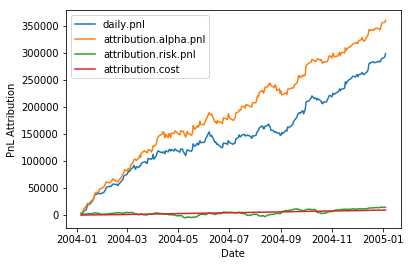

In [52]:
attr = build_pnl_attribution()

for column in attr.columns:
        plt.plot(attr[column].cumsum(), label=column)
plt.legend(loc='upper left')
plt.xlabel('Date')
plt.ylabel('PnL Attribution')
plt.show()

## Build portfolio characteristics (TODO)
Calculate the sum of long positions, short positions, net positions, gross market value, and amount of dollars traded.

In the code below, in the function `build_portfolio_characteristics` calculate the sum of long positions, short positions, net positions, gross market value, and amount of dollars traded.  

In [53]:
def build_portfolio_characteristics(): 
    df = pd.DataFrame(index = my_dates)
    
    for dt in my_dates:
        date = dt.strftime('%Y%m%d')
  
        p = port[date]
        tradelist = trades[date]
        h = p['opt.portfolio']['h.opt']
        
        # DONE: Implement
        
        # Calculate portfolio characteristics
        longs = np.sum(h[h > 0])  # Total long exposure
        shorts = np.sum(h[h < 0])  # Total short exposure
        net = longs + shorts  # Net exposure
        gmv = np.abs(longs) + np.abs(shorts)  # Gross Market Value (GMV)
        traded = np.sum(np.abs(tradelist['h.opt'] - tradelist['h.opt.previous']))  # Traded volume
        
        # Update the DataFrame with calculated characteristics
        df.at[dt, "long"] = longs
        df.at[dt, "short"] = shorts
        df.at[dt, "net"] = net
        df.at[dt, "gmv"] = gmv
        df.at[dt, "traded"] = traded        
          
    return df

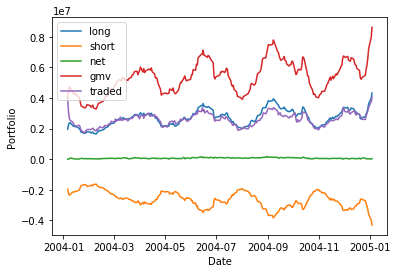

In [54]:
pchar = build_portfolio_characteristics()

for column in pchar.columns:
        plt.plot(pchar[column], label=column)
plt.legend(loc='upper left')
plt.xlabel('Date')
plt.ylabel('Portfolio')
plt.show()

#### Optional
Choose additional metrics to evaluate your portfolio.

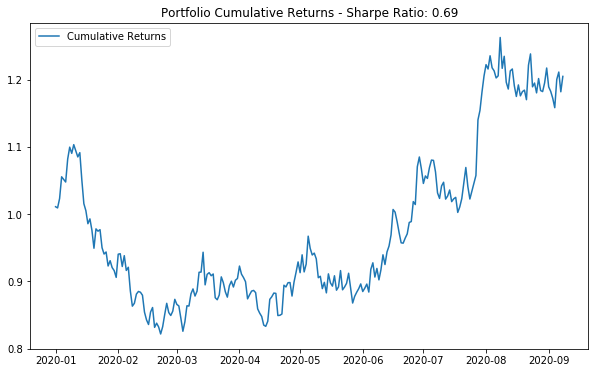

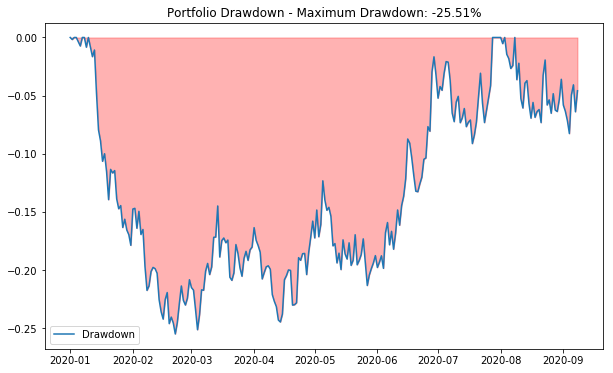

In [55]:
# Optional


np.random.seed(42)  # For reproducibility
dates = pd.date_range(start="2020-01-01", periods=252)  # A typical year of trading days
portfolio_returns = pd.Series(np.random.normal(0.001, 0.02, len(dates)), index=dates)

# Function to calculate and plot Sharpe Ratio
def calculate_and_plot_sharpe_ratio(returns, risk_free_rate=0.02):
    excess_returns = returns - (risk_free_rate / 252)
    sharpe_ratio = np.sqrt(252) * excess_returns.mean() / excess_returns.std()
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot((1 + returns).cumprod(), label="Cumulative Returns")
    plt.title(f"Portfolio Cumulative Returns - Sharpe Ratio: {sharpe_ratio:.2f}")
    plt.legend()
    plt.show()
    
    return sharpe_ratio

# Function to calculate and plot Maximum Drawdown
def calculate_and_plot_maximum_drawdown(returns):
    cumulative_returns = (1 + returns).cumprod()
    peak = cumulative_returns.expanding(min_periods=1).max()
    drawdown = (cumulative_returns / peak) - 1
    max_drawdown = drawdown.min()
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(drawdown, label="Drawdown")
    plt.fill_between(drawdown.index, drawdown.values, color='red', alpha=0.3)
    plt.title(f"Portfolio Drawdown - Maximum Drawdown: {max_drawdown*100:.2f}%")
    plt.legend()
    plt.show()
    
    return max_drawdown

# Calling the functions
sharpe_ratio = calculate_and_plot_sharpe_ratio(portfolio_returns)
max_drawdown = calculate_and_plot_maximum_drawdown(portfolio_returns)

## Submission
Now that you're done with the project, it's time to submit it. Click the submit button in the bottom right. One of our reviewers will give you feedback on your project with a pass or not passed grade.